# SSAP

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'

In [2]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [3]:
sys.path.append('../src/')

from SSAP import SSAP
from mydatasets import preprocess
import mydatasets as datasets
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
def num_parameters(m):
    return sum([np.prod(v.shape) for v in m.parameters()])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Prepare

In [5]:
# classとclassの色の呼び出し
with open('../data/t_class_name.txt', 'rb') as f:
    t_class_name = pickle.load(f)
with open('../data/t_color.txt', 'rb') as f:
    t_color = pickle.load(f)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
DATA_PATH = "../data/resize/"
IMG_SIZE = 224
# Affinity計算範囲
AFF_R = 5

mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda', index=0)

In [8]:
print(len(t_color))

81


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R)
# model = model.to(device)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train

In [10]:
# 実験ごとに名前(exp_1)を変更する.
# name = "../exp/exp_1/"
name = '../exp/raftsup_0pretrain_0/'

!mkdir -p $name
graph = name + "graph/"
!mkdir -p $graph
metrics = name + "metrics/"
!mkdir -p $metrics
trained_model = name + "trained_model/"
!mkdir -p $trained_model

BATCH_SIZE = 10
# BATCH_SIZE = 1

# EPOCH = 100000
EPOCH = 50
SAVE_ITER = 10000
# SAVe_ITER = 10
LOG_ITER = 10
# LOG_ITER = 1

aff_calc_weight = [1.5, 0.5]
aff_weight = 1.
l_aff_weight = [1., 0.3, 0.1, 0.03, 0.01]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
trained_model

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'../exp/raftsup_0pretrain_0/trained_model/'

In [12]:
# 各値の初期化
random.seed(0)  
np.random.seed(0)  
torch.manual_seed(0)
# img_path = DATA_PATH + "train2014/"
# img_t_path = DATA_PATH + "semantic_train/"
# img_t_ins_path = DATA_PATH + "instance_train/"

img_path = DATA_PATH + "val2017/"
img_t_path = DATA_PATH + "semantic_val/"
img_t_ins_path = DATA_PATH + "instance_val/"

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Datasetの設定
dataset = datasets.Mydatasets(t_color, img_path, img_t_path, img_t_ins_path,
                     IMG_SIZE, AFF_R, mean, std)
tdw_dataset = datasets.TdwAffinityDataset(training=True, mean=mean, std=std, 
                                          raft_ckpt=None, 
                                          single_supervision=False,
                                          full_supervision=False)

trainloader = torch.utils.data.DataLoader(tdw_dataset, batch_size = BATCH_SIZE,
                                          shuffle = True, num_workers = 4)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
len(dataset), len(tdw_dataset)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5000, 35789)

## look at example

In [15]:
data = dataset[0]
for v in data:
    print(v.dtype, v.shape, v.amin(), v.amax())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.float32 torch.Size([3, 224, 224]) tensor(-1.6796) tensor(1.6068)
torch.float64 torch.Size([81, 224, 224]) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.float32 torch.Size([5, 25, 224, 224]) tensor(0.) tensor(1.)


In [16]:
single_ex = 3
data = tdw_dataset[single_ex]
for v in data:
    print(v.dtype, v.shape, v.amin(), v.amax())

torch.float32 torch.Size([3, 256, 256]) tensor(-1.6520) tensor(1.9231)
torch.float32 torch.Size([2, 256, 256]) tensor(0.) tensor(1.)
torch.float32 torch.Size([5, 25, 256, 256]) tensor(0.) tensor(1.)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


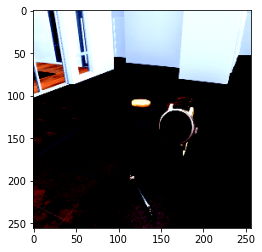

In [17]:
img, semantic, aff_target = data
plt.imshow(img.permute(1,2,0).numpy())
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


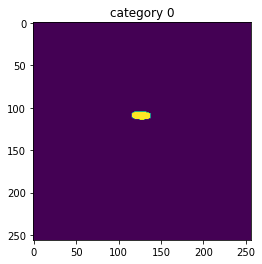

In [18]:
cats = torch.unique(semantic.argmax(0))
# cat_idx = cats[np.random.randint(1, len(cats))]
# plt.imshow(semantic[cat_idx].numpy())
cat_idx = 0
# plt.imshow(semantic.argmax(0).numpy())
plt.imshow(semantic[cat_idx].numpy())
plt.title('category %d' % cat_idx)
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


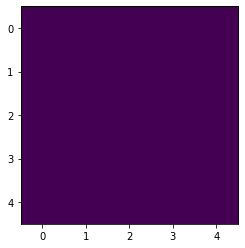

tensor([1.])


In [19]:
level = 4
node = (50,150)
affs = aff_target[level,:,node[0] // (2**level), node[1] // (2**level)].view(AFF_R, AFF_R)
plt.imshow(affs.numpy())
plt.show()
print(torch.unique(affs))

## train model

In [20]:
# Optimizerの指定
use_pretrained = False
model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R, pretrained_backbone=use_pretrained)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


iter:10, loss:0.3022, loss_seg:0.1397, loss_aff:0.1625
iter:20, loss:0.2777, loss_seg:0.1351, loss_aff:0.1426
iter:30, loss:0.2741, loss_seg:0.1626, loss_aff:0.1114
iter:40, loss:0.2878, loss_seg:0.1625, loss_aff:0.1253
iter:50, loss:0.2567, loss_seg:0.1552, loss_aff:0.1016
iter:60, loss:0.2730, loss_seg:0.1677, loss_aff:0.1054
iter:70, loss:0.1174, loss_seg:0.0662, loss_aff:0.0513
iter:80, loss:0.1558, loss_seg:0.0901, loss_aff:0.0657
iter:90, loss:0.2403, loss_seg:0.1504, loss_aff:0.0899
iter:100, loss:0.2404, loss_seg:0.1592, loss_aff:0.0813
iter:110, loss:0.2085, loss_seg:0.1251, loss_aff:0.0835
iter:120, loss:0.1882, loss_seg:0.1128, loss_aff:0.0753
iter:130, loss:0.1718, loss_seg:0.1063, loss_aff:0.0655
iter:140, loss:0.1778, loss_seg:0.1055, loss_aff:0.0723
iter:150, loss:0.2069, loss_seg:0.1281, loss_aff:0.0788
iter:160, loss:0.1611, loss_seg:0.0967, loss_aff:0.0644
iter:170, loss:0.1749, loss_seg:0.1148, loss_aff:0.0601
iter:180, loss:0.1751, loss_seg:0.1085, loss_aff:0.0665
i

iter:1450, loss:0.1981, loss_seg:0.1213, loss_aff:0.0767
iter:1460, loss:0.2397, loss_seg:0.1293, loss_aff:0.1105
iter:1470, loss:0.1822, loss_seg:0.1060, loss_aff:0.0762
iter:1480, loss:0.1811, loss_seg:0.1100, loss_aff:0.0711
iter:1490, loss:0.1723, loss_seg:0.1027, loss_aff:0.0697
iter:1500, loss:0.1635, loss_seg:0.0966, loss_aff:0.0669
iter:1510, loss:0.2758, loss_seg:0.1909, loss_aff:0.0850
iter:1520, loss:0.1312, loss_seg:0.0747, loss_aff:0.0565
iter:1530, loss:0.1340, loss_seg:0.0792, loss_aff:0.0548
iter:1540, loss:0.1163, loss_seg:0.0740, loss_aff:0.0423
iter:1550, loss:0.1451, loss_seg:0.0897, loss_aff:0.0554
iter:1560, loss:0.1463, loss_seg:0.0896, loss_aff:0.0567
iter:1570, loss:0.1609, loss_seg:0.0970, loss_aff:0.0638
iter:1580, loss:0.1279, loss_seg:0.0741, loss_aff:0.0538
iter:1590, loss:0.1975, loss_seg:0.1291, loss_aff:0.0684
iter:1600, loss:0.1666, loss_seg:0.1044, loss_aff:0.0621
iter:1610, loss:0.2258, loss_seg:0.1498, loss_aff:0.0760
iter:1620, loss:0.1244, loss_se

iter:2840, loss:0.1293, loss_seg:0.0718, loss_aff:0.0575
iter:2850, loss:0.2791, loss_seg:0.1890, loss_aff:0.0901
iter:2860, loss:0.1305, loss_seg:0.0820, loss_aff:0.0485
iter:2870, loss:0.1359, loss_seg:0.0767, loss_aff:0.0592
iter:2880, loss:0.1323, loss_seg:0.0797, loss_aff:0.0526
iter:2890, loss:0.1308, loss_seg:0.0810, loss_aff:0.0498
iter:2900, loss:0.2168, loss_seg:0.1386, loss_aff:0.0782
iter:2910, loss:0.1836, loss_seg:0.1179, loss_aff:0.0656
iter:2920, loss:0.1890, loss_seg:0.1105, loss_aff:0.0786
iter:2930, loss:0.1188, loss_seg:0.0685, loss_aff:0.0504
iter:2940, loss:0.0964, loss_seg:0.0579, loss_aff:0.0386
iter:2950, loss:0.0957, loss_seg:0.0559, loss_aff:0.0398
iter:2960, loss:0.1521, loss_seg:0.0952, loss_aff:0.0569
iter:2970, loss:0.1206, loss_seg:0.0741, loss_aff:0.0465
iter:2980, loss:0.1251, loss_seg:0.0740, loss_aff:0.0511
iter:2990, loss:0.1397, loss_seg:0.0888, loss_aff:0.0509
iter:3000, loss:0.1058, loss_seg:0.0642, loss_aff:0.0416
iter:3010, loss:0.2158, loss_se

iter:4260, loss:0.1111, loss_seg:0.0701, loss_aff:0.0410
iter:4270, loss:0.1512, loss_seg:0.0901, loss_aff:0.0611
iter:4280, loss:0.1924, loss_seg:0.1372, loss_aff:0.0552
iter:4290, loss:0.2746, loss_seg:0.2051, loss_aff:0.0695
iter:4300, loss:0.1354, loss_seg:0.0787, loss_aff:0.0567
iter:4310, loss:0.0951, loss_seg:0.0576, loss_aff:0.0375
iter:4320, loss:0.1509, loss_seg:0.0998, loss_aff:0.0511
iter:4330, loss:0.1666, loss_seg:0.1068, loss_aff:0.0599
iter:4340, loss:0.1856, loss_seg:0.1208, loss_aff:0.0648
iter:4350, loss:0.2035, loss_seg:0.1326, loss_aff:0.0708
iter:4360, loss:0.2101, loss_seg:0.1422, loss_aff:0.0679
iter:4370, loss:0.0948, loss_seg:0.0576, loss_aff:0.0372
iter:4380, loss:0.1311, loss_seg:0.0846, loss_aff:0.0465
iter:4390, loss:0.1556, loss_seg:0.0915, loss_aff:0.0641
iter:4400, loss:0.1168, loss_seg:0.0675, loss_aff:0.0493
iter:4410, loss:0.0844, loss_seg:0.0480, loss_aff:0.0364
iter:4420, loss:0.1237, loss_seg:0.0725, loss_aff:0.0513
iter:4430, loss:0.1538, loss_se

iter:5650, loss:0.0854, loss_seg:0.0485, loss_aff:0.0369
iter:5660, loss:0.1860, loss_seg:0.1207, loss_aff:0.0653
iter:5670, loss:0.0977, loss_seg:0.0573, loss_aff:0.0403
iter:5680, loss:0.0871, loss_seg:0.0485, loss_aff:0.0387
iter:5690, loss:0.1621, loss_seg:0.0956, loss_aff:0.0664
iter:5700, loss:0.1039, loss_seg:0.0627, loss_aff:0.0411
iter:5710, loss:0.1643, loss_seg:0.0987, loss_aff:0.0656
iter:5720, loss:0.1180, loss_seg:0.0701, loss_aff:0.0479
iter:5730, loss:0.1699, loss_seg:0.1024, loss_aff:0.0675
iter:5740, loss:0.2343, loss_seg:0.1567, loss_aff:0.0776
iter:5750, loss:0.0865, loss_seg:0.0513, loss_aff:0.0352
iter:5760, loss:0.1356, loss_seg:0.0826, loss_aff:0.0530
iter:5770, loss:0.1828, loss_seg:0.1145, loss_aff:0.0684
iter:5780, loss:0.1462, loss_seg:0.0980, loss_aff:0.0482
iter:5790, loss:0.1410, loss_seg:0.0891, loss_aff:0.0520
iter:5800, loss:0.1824, loss_seg:0.1178, loss_aff:0.0646
iter:5810, loss:0.1317, loss_seg:0.0777, loss_aff:0.0539
iter:5820, loss:0.1891, loss_se

iter:7090, loss:0.1175, loss_seg:0.0627, loss_aff:0.0548
iter:7100, loss:0.1610, loss_seg:0.0994, loss_aff:0.0617
iter:7110, loss:0.1500, loss_seg:0.0922, loss_aff:0.0578
iter:7120, loss:0.1394, loss_seg:0.0862, loss_aff:0.0532
iter:7130, loss:0.1332, loss_seg:0.0768, loss_aff:0.0564
iter:7140, loss:0.1414, loss_seg:0.0902, loss_aff:0.0512
iter:7150, loss:0.0924, loss_seg:0.0580, loss_aff:0.0344
iter:7160, loss:0.1174, loss_seg:0.0664, loss_aff:0.0509
iter:7170, loss:0.1141, loss_seg:0.0654, loss_aff:0.0487
iter:7180, loss:0.1025, loss_seg:0.0621, loss_aff:0.0404
iter:7190, loss:0.0870, loss_seg:0.0504, loss_aff:0.0366
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:7200, loss:0.1408, loss_seg:0.0867, loss_aff:0.0541
iter:7210, loss:0.0926, loss_seg:0.0527, loss_aff:0.0399
iter:7220, loss:0.1291, loss_seg:0.0745, loss_aff:0.0546
iter:7230, loss:0.1237, loss_seg:0.0776, loss_aff:0.0461
iter:72

iter:8480, loss:0.1393, loss_seg:0.0911, loss_aff:0.0482
iter:8490, loss:0.1095, loss_seg:0.0662, loss_aff:0.0433
iter:8500, loss:0.1296, loss_seg:0.0811, loss_aff:0.0485
iter:8510, loss:0.0954, loss_seg:0.0566, loss_aff:0.0388
iter:8520, loss:0.0989, loss_seg:0.0571, loss_aff:0.0418
iter:8530, loss:0.0977, loss_seg:0.0546, loss_aff:0.0432
iter:8540, loss:0.1472, loss_seg:0.0857, loss_aff:0.0614
iter:8550, loss:0.1251, loss_seg:0.0700, loss_aff:0.0550
iter:8560, loss:0.1326, loss_seg:0.0814, loss_aff:0.0512
iter:8570, loss:0.1038, loss_seg:0.0612, loss_aff:0.0425
iter:8580, loss:0.1028, loss_seg:0.0591, loss_aff:0.0437
iter:8590, loss:0.1518, loss_seg:0.0887, loss_aff:0.0631
iter:8600, loss:0.1725, loss_seg:0.1094, loss_aff:0.0631
iter:8610, loss:0.2349, loss_seg:0.1619, loss_aff:0.0729
iter:8620, loss:0.1082, loss_seg:0.0644, loss_aff:0.0438
iter:8630, loss:0.1561, loss_seg:0.0915, loss_aff:0.0646
iter:8640, loss:0.0992, loss_seg:0.0603, loss_aff:0.0389
iter:8650, loss:0.1427, loss_se

iter:9900, loss:0.1371, loss_seg:0.0773, loss_aff:0.0598
iter:9910, loss:0.0995, loss_seg:0.0623, loss_aff:0.0372
iter:9920, loss:0.1077, loss_seg:0.0651, loss_aff:0.0427
iter:9930, loss:0.1139, loss_seg:0.0696, loss_aff:0.0443
iter:9940, loss:0.1566, loss_seg:0.0935, loss_aff:0.0631
iter:9950, loss:0.0732, loss_seg:0.0403, loss_aff:0.0329
iter:9960, loss:0.1108, loss_seg:0.0670, loss_aff:0.0438
iter:9970, loss:0.1141, loss_seg:0.0723, loss_aff:0.0417
iter:9980, loss:0.1189, loss_seg:0.0700, loss_aff:0.0489
iter:9990, loss:0.1741, loss_seg:0.1042, loss_aff:0.0699
iter:10000, loss:0.1943, loss_seg:0.1278, loss_aff:0.0665


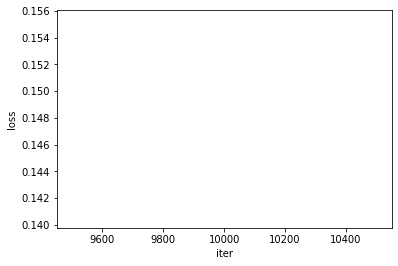

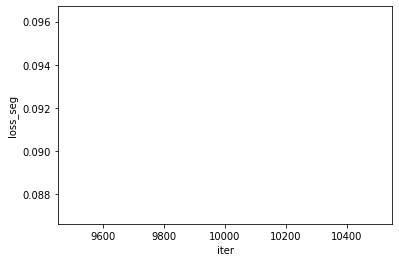

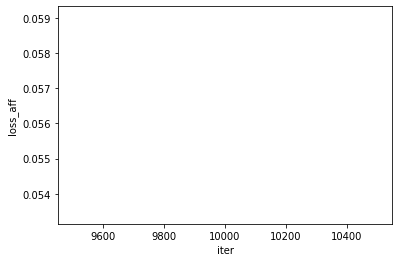

iter:10010, loss:0.1788, loss_seg:0.1059, loss_aff:0.0729
iter:10020, loss:0.1296, loss_seg:0.0782, loss_aff:0.0514
iter:10030, loss:0.1091, loss_seg:0.0653, loss_aff:0.0438
iter:10040, loss:0.1716, loss_seg:0.1046, loss_aff:0.0669
iter:10050, loss:0.1255, loss_seg:0.0755, loss_aff:0.0500
iter:10060, loss:0.1604, loss_seg:0.1054, loss_aff:0.0551
iter:10070, loss:0.1270, loss_seg:0.0771, loss_aff:0.0499
iter:10080, loss:0.0943, loss_seg:0.0586, loss_aff:0.0357
iter:10090, loss:0.1196, loss_seg:0.0712, loss_aff:0.0484
iter:10100, loss:0.1173, loss_seg:0.0714, loss_aff:0.0459
iter:10110, loss:0.1741, loss_seg:0.1110, loss_aff:0.0630
iter:10120, loss:0.1749, loss_seg:0.1125, loss_aff:0.0624
iter:10130, loss:0.1366, loss_seg:0.0874, loss_aff:0.0492
iter:10140, loss:0.1646, loss_seg:0.1013, loss_aff:0.0633
iter:10150, loss:0.1268, loss_seg:0.0772, loss_aff:0.0496
iter:10160, loss:0.1500, loss_seg:0.0880, loss_aff:0.0620
iter:10170, loss:0.1219, loss_seg:0.0706, loss_aff:0.0513
iter:10180, lo

iter:11410, loss:0.1423, loss_seg:0.0841, loss_aff:0.0583
iter:11420, loss:0.1259, loss_seg:0.0721, loss_aff:0.0537
iter:11430, loss:0.1061, loss_seg:0.0608, loss_aff:0.0453
iter:11440, loss:0.1750, loss_seg:0.1146, loss_aff:0.0604
iter:11450, loss:0.1307, loss_seg:0.0815, loss_aff:0.0492
iter:11460, loss:0.1099, loss_seg:0.0666, loss_aff:0.0433
iter:11470, loss:0.1307, loss_seg:0.0787, loss_aff:0.0520
iter:11480, loss:0.1271, loss_seg:0.0801, loss_aff:0.0470
iter:11490, loss:0.1500, loss_seg:0.0963, loss_aff:0.0538
iter:11500, loss:0.1094, loss_seg:0.0638, loss_aff:0.0456
iter:11510, loss:0.1076, loss_seg:0.0596, loss_aff:0.0479
iter:11520, loss:0.1422, loss_seg:0.0895, loss_aff:0.0527
iter:11530, loss:0.2094, loss_seg:0.1390, loss_aff:0.0704
iter:11540, loss:0.1178, loss_seg:0.0693, loss_aff:0.0485
iter:11550, loss:0.0875, loss_seg:0.0527, loss_aff:0.0348
iter:11560, loss:0.1057, loss_seg:0.0639, loss_aff:0.0418
iter:11570, loss:0.1202, loss_seg:0.0736, loss_aff:0.0466
iter:11580, lo

iter:12800, loss:0.1180, loss_seg:0.0730, loss_aff:0.0450
iter:12810, loss:0.1429, loss_seg:0.0936, loss_aff:0.0493
iter:12820, loss:0.1420, loss_seg:0.0857, loss_aff:0.0564
iter:12830, loss:0.1082, loss_seg:0.0638, loss_aff:0.0444
iter:12840, loss:0.0692, loss_seg:0.0375, loss_aff:0.0317
iter:12850, loss:0.1260, loss_seg:0.0779, loss_aff:0.0481
iter:12860, loss:0.1509, loss_seg:0.0938, loss_aff:0.0571
iter:12870, loss:0.1014, loss_seg:0.0587, loss_aff:0.0427
iter:12880, loss:0.2324, loss_seg:0.1575, loss_aff:0.0749
iter:12890, loss:0.1419, loss_seg:0.0913, loss_aff:0.0506
iter:12900, loss:0.0881, loss_seg:0.0561, loss_aff:0.0320
iter:12910, loss:0.1301, loss_seg:0.0803, loss_aff:0.0498
iter:12920, loss:0.0681, loss_seg:0.0395, loss_aff:0.0286
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:12930, loss:0.1201, loss_seg:0.0719, loss_aff:0.0483
iter:12940, loss:0.1078, loss_seg:0.0612, loss_aff

iter:14190, loss:0.0991, loss_seg:0.0587, loss_aff:0.0404
iter:14200, loss:0.0884, loss_seg:0.0577, loss_aff:0.0306
iter:14210, loss:0.1186, loss_seg:0.0680, loss_aff:0.0507
iter:14220, loss:0.0953, loss_seg:0.0584, loss_aff:0.0369
iter:14230, loss:0.1137, loss_seg:0.0705, loss_aff:0.0432
iter:14240, loss:0.1074, loss_seg:0.0637, loss_aff:0.0437
iter:14250, loss:0.0823, loss_seg:0.0478, loss_aff:0.0345
iter:14260, loss:0.0937, loss_seg:0.0536, loss_aff:0.0401
iter:14270, loss:0.1057, loss_seg:0.0638, loss_aff:0.0419
iter:14280, loss:0.1575, loss_seg:0.1000, loss_aff:0.0575
iter:14290, loss:0.0991, loss_seg:0.0625, loss_aff:0.0366
iter:14300, loss:0.0608, loss_seg:0.0361, loss_aff:0.0247
iter:14310, loss:0.1471, loss_seg:0.0953, loss_aff:0.0518
iter:14320, loss:0.1357, loss_seg:0.0750, loss_aff:0.0607
iter:14330, loss:0.1232, loss_seg:0.0772, loss_aff:0.0460
iter:14340, loss:0.1229, loss_seg:0.0759, loss_aff:0.0470
iter:14350, loss:0.0929, loss_seg:0.0579, loss_aff:0.0350
iter:14360, lo

iter:15560, loss:0.1217, loss_seg:0.0737, loss_aff:0.0481
iter:15570, loss:0.1017, loss_seg:0.0587, loss_aff:0.0431
iter:15580, loss:0.0870, loss_seg:0.0478, loss_aff:0.0392
iter:15590, loss:0.1174, loss_seg:0.0737, loss_aff:0.0436
iter:15600, loss:0.0941, loss_seg:0.0543, loss_aff:0.0398
iter:15610, loss:0.0882, loss_seg:0.0512, loss_aff:0.0370
iter:15620, loss:0.1224, loss_seg:0.0738, loss_aff:0.0486
iter:15630, loss:0.1188, loss_seg:0.0761, loss_aff:0.0426
iter:15640, loss:0.1204, loss_seg:0.0691, loss_aff:0.0514
iter:15650, loss:0.1308, loss_seg:0.0777, loss_aff:0.0531
iter:15660, loss:0.2201, loss_seg:0.1600, loss_aff:0.0601
iter:15670, loss:0.1413, loss_seg:0.0959, loss_aff:0.0454
iter:15680, loss:0.1288, loss_seg:0.0823, loss_aff:0.0465
iter:15690, loss:0.1290, loss_seg:0.0790, loss_aff:0.0499
iter:15700, loss:0.1285, loss_seg:0.0816, loss_aff:0.0469
iter:15710, loss:0.1122, loss_seg:0.0646, loss_aff:0.0476
iter:15720, loss:0.0995, loss_seg:0.0612, loss_aff:0.0382
iter:15730, lo

iter:16950, loss:0.1259, loss_seg:0.0828, loss_aff:0.0430
iter:16960, loss:0.0951, loss_seg:0.0561, loss_aff:0.0390
iter:16970, loss:0.1096, loss_seg:0.0662, loss_aff:0.0434
iter:16980, loss:0.0840, loss_seg:0.0528, loss_aff:0.0312
iter:16990, loss:0.1453, loss_seg:0.0923, loss_aff:0.0530
iter:17000, loss:0.0970, loss_seg:0.0587, loss_aff:0.0383
iter:17010, loss:0.1028, loss_seg:0.0602, loss_aff:0.0426
iter:17020, loss:0.1080, loss_seg:0.0642, loss_aff:0.0438
iter:17030, loss:0.1126, loss_seg:0.0685, loss_aff:0.0441
iter:17040, loss:0.1088, loss_seg:0.0659, loss_aff:0.0429
iter:17050, loss:0.1463, loss_seg:0.0911, loss_aff:0.0552
iter:17060, loss:0.0936, loss_seg:0.0543, loss_aff:0.0394
iter:17070, loss:0.1036, loss_seg:0.0598, loss_aff:0.0438
iter:17080, loss:0.0903, loss_seg:0.0528, loss_aff:0.0375
iter:17090, loss:0.0844, loss_seg:0.0489, loss_aff:0.0355
iter:17100, loss:0.1041, loss_seg:0.0648, loss_aff:0.0392
iter:17110, loss:0.0879, loss_seg:0.0501, loss_aff:0.0378
iter:17120, lo

iter:18340, loss:0.1210, loss_seg:0.0796, loss_aff:0.0414
iter:18350, loss:0.1438, loss_seg:0.0920, loss_aff:0.0518
iter:18360, loss:0.0923, loss_seg:0.0553, loss_aff:0.0370
iter:18370, loss:0.1090, loss_seg:0.0695, loss_aff:0.0395
iter:18380, loss:0.0862, loss_seg:0.0533, loss_aff:0.0328
iter:18390, loss:0.1086, loss_seg:0.0662, loss_aff:0.0424
iter:18400, loss:0.1442, loss_seg:0.0960, loss_aff:0.0482
iter:18410, loss:0.0950, loss_seg:0.0568, loss_aff:0.0382
iter:18420, loss:0.1132, loss_seg:0.0701, loss_aff:0.0431
iter:18430, loss:0.1005, loss_seg:0.0620, loss_aff:0.0385
iter:18440, loss:0.1048, loss_seg:0.0594, loss_aff:0.0454
iter:18450, loss:0.0851, loss_seg:0.0516, loss_aff:0.0335
iter:18460, loss:0.1407, loss_seg:0.0901, loss_aff:0.0506
iter:18470, loss:0.1178, loss_seg:0.0764, loss_aff:0.0415
iter:18480, loss:0.1130, loss_seg:0.0659, loss_aff:0.0471
iter:18490, loss:0.0898, loss_seg:0.0522, loss_aff:0.0376
iter:18500, loss:0.1001, loss_seg:0.0616, loss_aff:0.0385
iter:18510, lo

iter:19730, loss:0.1506, loss_seg:0.0925, loss_aff:0.0581
iter:19740, loss:0.1227, loss_seg:0.0733, loss_aff:0.0494
iter:19750, loss:0.1210, loss_seg:0.0776, loss_aff:0.0433
iter:19760, loss:0.1198, loss_seg:0.0738, loss_aff:0.0460
iter:19770, loss:0.1513, loss_seg:0.0980, loss_aff:0.0532
iter:19780, loss:0.0984, loss_seg:0.0640, loss_aff:0.0344
iter:19790, loss:0.1066, loss_seg:0.0640, loss_aff:0.0426
iter:19800, loss:0.0948, loss_seg:0.0584, loss_aff:0.0364
iter:19810, loss:0.0839, loss_seg:0.0457, loss_aff:0.0382
iter:19820, loss:0.1047, loss_seg:0.0662, loss_aff:0.0385
iter:19830, loss:0.1251, loss_seg:0.0741, loss_aff:0.0510
iter:19840, loss:0.0939, loss_seg:0.0550, loss_aff:0.0388
iter:19850, loss:0.0882, loss_seg:0.0512, loss_aff:0.0371
iter:19860, loss:0.1322, loss_seg:0.0795, loss_aff:0.0528
iter:19870, loss:0.1281, loss_seg:0.0835, loss_aff:0.0446
iter:19880, loss:0.1044, loss_seg:0.0604, loss_aff:0.0440
iter:19890, loss:0.1016, loss_seg:0.0580, loss_aff:0.0437
iter:19900, lo

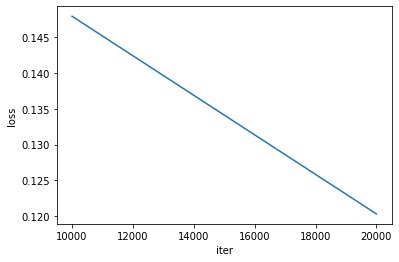

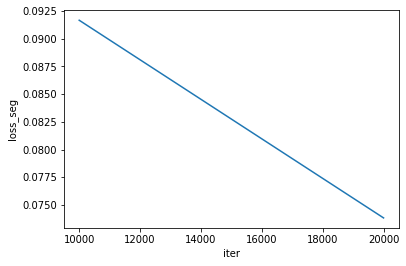

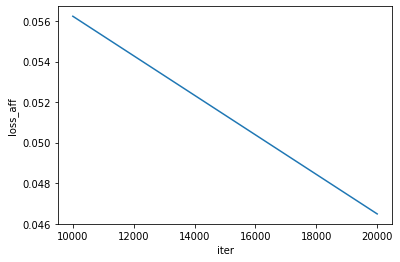

iter:20010, loss:0.1109, loss_seg:0.0711, loss_aff:0.0398
iter:20020, loss:0.1125, loss_seg:0.0682, loss_aff:0.0443
iter:20030, loss:0.1086, loss_seg:0.0637, loss_aff:0.0449
iter:20040, loss:0.0735, loss_seg:0.0432, loss_aff:0.0302
iter:20050, loss:0.1000, loss_seg:0.0599, loss_aff:0.0401
iter:20060, loss:0.0846, loss_seg:0.0491, loss_aff:0.0355
iter:20070, loss:0.1384, loss_seg:0.0877, loss_aff:0.0507
iter:20080, loss:0.1145, loss_seg:0.0687, loss_aff:0.0458
iter:20090, loss:0.1128, loss_seg:0.0687, loss_aff:0.0441
iter:20100, loss:0.1187, loss_seg:0.0741, loss_aff:0.0446
iter:20110, loss:0.1155, loss_seg:0.0718, loss_aff:0.0436
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:20120, loss:0.0798, loss_seg:0.0483, loss_aff:0.0315
iter:20130, loss:0.1063, loss_seg:0.0665, loss_aff:0.0397
iter:20140, loss:0.0784, loss_seg:0.0464, loss_aff:0.0321
iter:20150, loss:0.1550, loss_seg:0.0946, loss_aff

iter:21400, loss:0.1036, loss_seg:0.0651, loss_aff:0.0385
iter:21410, loss:0.0900, loss_seg:0.0518, loss_aff:0.0383
iter:21420, loss:0.1430, loss_seg:0.0912, loss_aff:0.0518
iter:21430, loss:0.1357, loss_seg:0.0811, loss_aff:0.0547
iter:21440, loss:0.1002, loss_seg:0.0543, loss_aff:0.0459
iter:21450, loss:0.1024, loss_seg:0.0603, loss_aff:0.0421
iter:21460, loss:0.0828, loss_seg:0.0454, loss_aff:0.0373
iter:21470, loss:0.0889, loss_seg:0.0480, loss_aff:0.0408
iter:21480, loss:0.1539, loss_seg:0.0964, loss_aff:0.0575
iter:21490, loss:0.1173, loss_seg:0.0660, loss_aff:0.0513
iter:21500, loss:0.1130, loss_seg:0.0699, loss_aff:0.0430
iter:21510, loss:0.0959, loss_seg:0.0598, loss_aff:0.0361
iter:21520, loss:0.1046, loss_seg:0.0659, loss_aff:0.0387
iter:21530, loss:0.1271, loss_seg:0.0827, loss_aff:0.0444
iter:21540, loss:0.1242, loss_seg:0.0773, loss_aff:0.0469
iter:21550, loss:0.0886, loss_seg:0.0520, loss_aff:0.0365
iter:21560, loss:0.1007, loss_seg:0.0581, loss_aff:0.0427
iter:21570, lo

iter:22770, loss:0.1522, loss_seg:0.0981, loss_aff:0.0540
iter:22780, loss:0.0801, loss_seg:0.0492, loss_aff:0.0309
iter:22790, loss:0.0786, loss_seg:0.0423, loss_aff:0.0363
iter:22800, loss:0.1044, loss_seg:0.0616, loss_aff:0.0428
iter:22810, loss:0.0937, loss_seg:0.0615, loss_aff:0.0322
iter:22820, loss:0.0870, loss_seg:0.0521, loss_aff:0.0349
iter:22830, loss:0.0972, loss_seg:0.0572, loss_aff:0.0400
iter:22840, loss:0.0977, loss_seg:0.0595, loss_aff:0.0382
iter:22850, loss:0.0864, loss_seg:0.0500, loss_aff:0.0363
iter:22860, loss:0.0851, loss_seg:0.0519, loss_aff:0.0332
iter:22870, loss:0.1394, loss_seg:0.0885, loss_aff:0.0509
iter:22880, loss:0.0614, loss_seg:0.0357, loss_aff:0.0257
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:22890, loss:0.0973, loss_seg:0.0607, loss_aff:0.0366
iter:22900, loss:0.0990, loss_seg:0.0600, loss_aff:0.0390
iter:22910, loss:0.1469, loss_seg:0.0945, loss_aff

iter:24160, loss:0.0988, loss_seg:0.0614, loss_aff:0.0374
iter:24170, loss:0.0950, loss_seg:0.0570, loss_aff:0.0380
iter:24180, loss:0.1112, loss_seg:0.0639, loss_aff:0.0473
iter:24190, loss:0.1141, loss_seg:0.0697, loss_aff:0.0443
iter:24200, loss:0.1071, loss_seg:0.0714, loss_aff:0.0356
iter:24210, loss:0.0945, loss_seg:0.0517, loss_aff:0.0428
iter:24220, loss:0.1350, loss_seg:0.0814, loss_aff:0.0536
iter:24230, loss:0.1398, loss_seg:0.0972, loss_aff:0.0426
iter:24240, loss:0.0858, loss_seg:0.0484, loss_aff:0.0374
iter:24250, loss:0.1144, loss_seg:0.0653, loss_aff:0.0491
iter:24260, loss:0.0820, loss_seg:0.0475, loss_aff:0.0345
iter:24270, loss:0.1077, loss_seg:0.0653, loss_aff:0.0424
iter:24280, loss:0.1217, loss_seg:0.0766, loss_aff:0.0450
iter:24290, loss:0.1050, loss_seg:0.0595, loss_aff:0.0456
iter:24300, loss:0.1102, loss_seg:0.0602, loss_aff:0.0500
iter:24310, loss:0.0881, loss_seg:0.0501, loss_aff:0.0381
iter:24320, loss:0.0999, loss_seg:0.0544, loss_aff:0.0455
iter:24330, lo

iter:25580, loss:0.0558, loss_seg:0.0348, loss_aff:0.0210
iter:25590, loss:0.0950, loss_seg:0.0580, loss_aff:0.0370
iter:25600, loss:0.0663, loss_seg:0.0392, loss_aff:0.0270
iter:25610, loss:0.0968, loss_seg:0.0599, loss_aff:0.0368
iter:25620, loss:0.0804, loss_seg:0.0457, loss_aff:0.0347
iter:25630, loss:0.0941, loss_seg:0.0555, loss_aff:0.0386
iter:25640, loss:0.1194, loss_seg:0.0735, loss_aff:0.0459
iter:25650, loss:0.0813, loss_seg:0.0432, loss_aff:0.0382
iter:25660, loss:0.0888, loss_seg:0.0519, loss_aff:0.0369
iter:25670, loss:0.0855, loss_seg:0.0509, loss_aff:0.0346
iter:25680, loss:0.0873, loss_seg:0.0464, loss_aff:0.0408
iter:25690, loss:0.1254, loss_seg:0.0817, loss_aff:0.0438
iter:25700, loss:0.1032, loss_seg:0.0629, loss_aff:0.0403
iter:25710, loss:0.1098, loss_seg:0.0656, loss_aff:0.0442
iter:25720, loss:0.1237, loss_seg:0.0840, loss_aff:0.0396
iter:25730, loss:0.0780, loss_seg:0.0476, loss_aff:0.0304
iter:25740, loss:0.0631, loss_seg:0.0358, loss_aff:0.0273
iter:25750, lo

iter:26950, loss:0.0737, loss_seg:0.0398, loss_aff:0.0340
iter:26960, loss:0.0901, loss_seg:0.0547, loss_aff:0.0354
iter:26970, loss:0.1291, loss_seg:0.0821, loss_aff:0.0470
iter:26980, loss:0.0794, loss_seg:0.0462, loss_aff:0.0332
iter:26990, loss:0.0828, loss_seg:0.0496, loss_aff:0.0333
iter:27000, loss:0.0628, loss_seg:0.0385, loss_aff:0.0243
iter:27010, loss:0.1064, loss_seg:0.0635, loss_aff:0.0429
iter:27020, loss:0.0845, loss_seg:0.0495, loss_aff:0.0350
iter:27030, loss:0.0944, loss_seg:0.0590, loss_aff:0.0353
iter:27040, loss:0.1459, loss_seg:0.0951, loss_aff:0.0508
iter:27050, loss:0.1503, loss_seg:0.1028, loss_aff:0.0475
iter:27060, loss:0.1185, loss_seg:0.0750, loss_aff:0.0435
iter:27070, loss:0.1338, loss_seg:0.0850, loss_aff:0.0488
iter:27080, loss:0.1383, loss_seg:0.0878, loss_aff:0.0505
iter:27090, loss:0.1716, loss_seg:0.1018, loss_aff:0.0698
iter:27100, loss:0.1304, loss_seg:0.0789, loss_aff:0.0515
iter:27110, loss:0.1424, loss_seg:0.0953, loss_aff:0.0471
iter:27120, lo

iter:28340, loss:0.0679, loss_seg:0.0380, loss_aff:0.0299
iter:28350, loss:0.1079, loss_seg:0.0688, loss_aff:0.0392
iter:28360, loss:0.1169, loss_seg:0.0713, loss_aff:0.0456
iter:28370, loss:0.0607, loss_seg:0.0412, loss_aff:0.0194
iter:28380, loss:0.1370, loss_seg:0.0911, loss_aff:0.0460
iter:28390, loss:0.1251, loss_seg:0.0747, loss_aff:0.0504
iter:28400, loss:0.1734, loss_seg:0.1216, loss_aff:0.0518
iter:28410, loss:0.0644, loss_seg:0.0390, loss_aff:0.0254
iter:28420, loss:0.0730, loss_seg:0.0449, loss_aff:0.0280
iter:28430, loss:0.1347, loss_seg:0.0836, loss_aff:0.0511
iter:28440, loss:0.1531, loss_seg:0.0984, loss_aff:0.0547
iter:28450, loss:0.0964, loss_seg:0.0618, loss_aff:0.0346
iter:28460, loss:0.0754, loss_seg:0.0418, loss_aff:0.0336
iter:28470, loss:0.0477, loss_seg:0.0269, loss_aff:0.0208
iter:28480, loss:0.1067, loss_seg:0.0719, loss_aff:0.0348
iter:28490, loss:0.1453, loss_seg:0.0910, loss_aff:0.0543
iter:28500, loss:0.1194, loss_seg:0.0782, loss_aff:0.0412
iter:28510, lo

iter:29730, loss:0.0797, loss_seg:0.0428, loss_aff:0.0369
iter:29740, loss:0.1098, loss_seg:0.0644, loss_aff:0.0454
iter:29750, loss:0.0980, loss_seg:0.0635, loss_aff:0.0345
iter:29760, loss:0.0893, loss_seg:0.0545, loss_aff:0.0348
iter:29770, loss:0.1211, loss_seg:0.0779, loss_aff:0.0432
iter:29780, loss:0.1210, loss_seg:0.0735, loss_aff:0.0475
iter:29790, loss:0.1038, loss_seg:0.0645, loss_aff:0.0393
iter:29800, loss:0.1081, loss_seg:0.0719, loss_aff:0.0362
iter:29810, loss:0.0919, loss_seg:0.0513, loss_aff:0.0406
iter:29820, loss:0.0571, loss_seg:0.0324, loss_aff:0.0247
iter:29830, loss:0.1229, loss_seg:0.0749, loss_aff:0.0480
iter:29840, loss:0.0983, loss_seg:0.0557, loss_aff:0.0426
iter:29850, loss:0.1380, loss_seg:0.0935, loss_aff:0.0445
iter:29860, loss:0.0820, loss_seg:0.0449, loss_aff:0.0370
iter:29870, loss:0.0780, loss_seg:0.0469, loss_aff:0.0311
iter:29880, loss:0.0995, loss_seg:0.0609, loss_aff:0.0386
iter:29890, loss:0.1121, loss_seg:0.0743, loss_aff:0.0378
iter:29900, lo

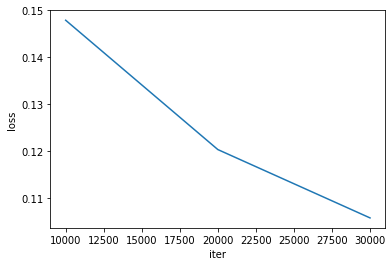

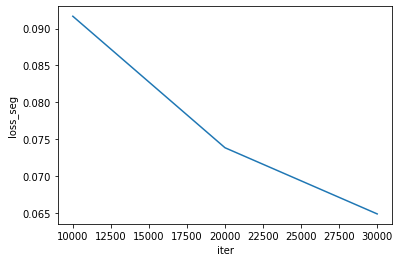

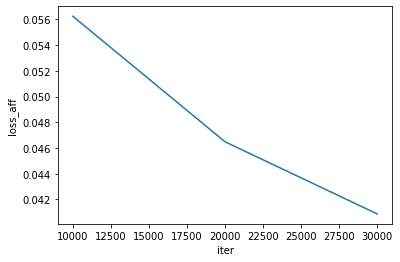

iter:30010, loss:0.0825, loss_seg:0.0493, loss_aff:0.0332
iter:30020, loss:0.1186, loss_seg:0.0760, loss_aff:0.0426
iter:30030, loss:0.0939, loss_seg:0.0591, loss_aff:0.0349
iter:30040, loss:0.1958, loss_seg:0.1258, loss_aff:0.0700
iter:30050, loss:0.1039, loss_seg:0.0637, loss_aff:0.0403
iter:30060, loss:0.0864, loss_seg:0.0528, loss_aff:0.0335
iter:30070, loss:0.0696, loss_seg:0.0441, loss_aff:0.0255
iter:30080, loss:0.0785, loss_seg:0.0454, loss_aff:0.0331
iter:30090, loss:0.0864, loss_seg:0.0589, loss_aff:0.0275
iter:30100, loss:0.1060, loss_seg:0.0645, loss_aff:0.0415
iter:30110, loss:0.1147, loss_seg:0.0695, loss_aff:0.0452
iter:30120, loss:0.1045, loss_seg:0.0621, loss_aff:0.0424
iter:30130, loss:0.0952, loss_seg:0.0536, loss_aff:0.0416
iter:30140, loss:0.0852, loss_seg:0.0535, loss_aff:0.0317
iter:30150, loss:0.1079, loss_seg:0.0631, loss_aff:0.0448
iter:30160, loss:0.0983, loss_seg:0.0612, loss_aff:0.0371
iter:30170, loss:0.1282, loss_seg:0.0740, loss_aff:0.0542
iter:30180, lo

iter:31400, loss:0.0916, loss_seg:0.0540, loss_aff:0.0376
iter:31410, loss:0.1122, loss_seg:0.0650, loss_aff:0.0473
iter:31420, loss:0.1429, loss_seg:0.0902, loss_aff:0.0527
iter:31430, loss:0.1372, loss_seg:0.0838, loss_aff:0.0534
iter:31440, loss:0.0769, loss_seg:0.0533, loss_aff:0.0236
iter:31450, loss:0.0985, loss_seg:0.0577, loss_aff:0.0408
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:31460, loss:0.0906, loss_seg:0.0513, loss_aff:0.0393
iter:31470, loss:0.1130, loss_seg:0.0772, loss_aff:0.0358
iter:31480, loss:0.1564, loss_seg:0.1077, loss_aff:0.0487
iter:31490, loss:0.0894, loss_seg:0.0565, loss_aff:0.0329
iter:31500, loss:0.0901, loss_seg:0.0586, loss_aff:0.0314
iter:31510, loss:0.0726, loss_seg:0.0478, loss_aff:0.0248
iter:31520, loss:0.1400, loss_seg:0.0925, loss_aff:0.0475
iter:31530, loss:0.1305, loss_seg:0.0913, loss_aff:0.0392
iter:31540, loss:0.0848, loss_seg:0.0523, loss_aff:

iter:32790, loss:0.0611, loss_seg:0.0328, loss_aff:0.0283
iter:32800, loss:0.1266, loss_seg:0.0809, loss_aff:0.0457
iter:32810, loss:0.0868, loss_seg:0.0540, loss_aff:0.0328
iter:32820, loss:0.0635, loss_seg:0.0363, loss_aff:0.0272
iter:32830, loss:0.0636, loss_seg:0.0374, loss_aff:0.0261
iter:32840, loss:0.0901, loss_seg:0.0510, loss_aff:0.0392
iter:32850, loss:0.0967, loss_seg:0.0576, loss_aff:0.0391
iter:32860, loss:0.0852, loss_seg:0.0510, loss_aff:0.0341
iter:32870, loss:0.0962, loss_seg:0.0595, loss_aff:0.0367
iter:32880, loss:0.0971, loss_seg:0.0659, loss_aff:0.0312
iter:32890, loss:0.0869, loss_seg:0.0534, loss_aff:0.0334
iter:32900, loss:0.0851, loss_seg:0.0511, loss_aff:0.0340
iter:32910, loss:0.0929, loss_seg:0.0580, loss_aff:0.0349
iter:32920, loss:0.0689, loss_seg:0.0412, loss_aff:0.0278
iter:32930, loss:0.0891, loss_seg:0.0534, loss_aff:0.0357
iter:32940, loss:0.1154, loss_seg:0.0733, loss_aff:0.0421
iter:32950, loss:0.0874, loss_seg:0.0614, loss_aff:0.0260
iter:32960, lo

iter:34210, loss:0.0649, loss_seg:0.0346, loss_aff:0.0302
iter:34220, loss:0.0586, loss_seg:0.0336, loss_aff:0.0250
iter:34230, loss:0.1101, loss_seg:0.0669, loss_aff:0.0432
iter:34240, loss:0.1058, loss_seg:0.0693, loss_aff:0.0365
iter:34250, loss:0.1066, loss_seg:0.0726, loss_aff:0.0339
iter:34260, loss:0.0669, loss_seg:0.0385, loss_aff:0.0284
iter:34270, loss:0.1315, loss_seg:0.0857, loss_aff:0.0458
iter:34280, loss:0.1028, loss_seg:0.0620, loss_aff:0.0409
iter:34290, loss:0.1051, loss_seg:0.0656, loss_aff:0.0395
iter:34300, loss:0.1234, loss_seg:0.0759, loss_aff:0.0474
iter:34310, loss:0.1441, loss_seg:0.0856, loss_aff:0.0585
iter:34320, loss:0.1017, loss_seg:0.0616, loss_aff:0.0401
iter:34330, loss:0.0912, loss_seg:0.0607, loss_aff:0.0305
iter:34340, loss:0.1061, loss_seg:0.0638, loss_aff:0.0423
iter:34350, loss:0.0941, loss_seg:0.0613, loss_aff:0.0328
iter:34360, loss:0.1225, loss_seg:0.0780, loss_aff:0.0445
iter:34370, loss:0.1018, loss_seg:0.0643, loss_aff:0.0375
iter:34380, lo

iter:35580, loss:0.1026, loss_seg:0.0647, loss_aff:0.0379
iter:35590, loss:0.0663, loss_seg:0.0365, loss_aff:0.0298
iter:35600, loss:0.0664, loss_seg:0.0425, loss_aff:0.0239
iter:35610, loss:0.1452, loss_seg:0.0926, loss_aff:0.0526
iter:35620, loss:0.1211, loss_seg:0.0815, loss_aff:0.0396
iter:35630, loss:0.0736, loss_seg:0.0466, loss_aff:0.0270
iter:35640, loss:0.0709, loss_seg:0.0434, loss_aff:0.0275
iter:35650, loss:0.0876, loss_seg:0.0494, loss_aff:0.0382
iter:35660, loss:0.1379, loss_seg:0.0878, loss_aff:0.0501
iter:35670, loss:0.0969, loss_seg:0.0626, loss_aff:0.0343
iter:35680, loss:0.1208, loss_seg:0.0810, loss_aff:0.0399
iter:35690, loss:0.1048, loss_seg:0.0640, loss_aff:0.0408
iter:35700, loss:0.1362, loss_seg:0.0809, loss_aff:0.0553
iter:35710, loss:0.0748, loss_seg:0.0467, loss_aff:0.0281
iter:35720, loss:0.1290, loss_seg:0.0777, loss_aff:0.0514
iter:35730, loss:0.0708, loss_seg:0.0437, loss_aff:0.0270
iter:35740, loss:0.1326, loss_seg:0.0871, loss_aff:0.0455
iter:35750, lo

iter:36970, loss:0.0649, loss_seg:0.0392, loss_aff:0.0257
iter:36980, loss:0.1056, loss_seg:0.0638, loss_aff:0.0419
iter:36990, loss:0.1127, loss_seg:0.0718, loss_aff:0.0410
iter:37000, loss:0.0961, loss_seg:0.0599, loss_aff:0.0362
iter:37010, loss:0.0980, loss_seg:0.0561, loss_aff:0.0419
iter:37020, loss:0.1081, loss_seg:0.0671, loss_aff:0.0409
iter:37030, loss:0.1094, loss_seg:0.0666, loss_aff:0.0429
iter:37040, loss:0.0826, loss_seg:0.0520, loss_aff:0.0307
iter:37050, loss:0.0757, loss_seg:0.0430, loss_aff:0.0326
iter:37060, loss:0.1623, loss_seg:0.1086, loss_aff:0.0537
iter:37070, loss:0.1247, loss_seg:0.0765, loss_aff:0.0482
iter:37080, loss:0.0833, loss_seg:0.0536, loss_aff:0.0297
iter:37090, loss:0.0752, loss_seg:0.0471, loss_aff:0.0282
iter:37100, loss:0.0865, loss_seg:0.0517, loss_aff:0.0348
iter:37110, loss:0.0795, loss_seg:0.0446, loss_aff:0.0349
iter:37120, loss:0.0659, loss_seg:0.0427, loss_aff:0.0233
iter:37130, loss:0.1298, loss_seg:0.0823, loss_aff:0.0475
Encounter erro

iter:38360, loss:0.0810, loss_seg:0.0497, loss_aff:0.0312
iter:38370, loss:0.1034, loss_seg:0.0586, loss_aff:0.0448
iter:38380, loss:0.0790, loss_seg:0.0473, loss_aff:0.0317
iter:38390, loss:0.1046, loss_seg:0.0635, loss_aff:0.0412
iter:38400, loss:0.0698, loss_seg:0.0379, loss_aff:0.0319
iter:38410, loss:0.0806, loss_seg:0.0476, loss_aff:0.0331
iter:38420, loss:0.1021, loss_seg:0.0636, loss_aff:0.0384
iter:38430, loss:0.0941, loss_seg:0.0545, loss_aff:0.0396
iter:38440, loss:0.0946, loss_seg:0.0573, loss_aff:0.0372
iter:38450, loss:0.0734, loss_seg:0.0458, loss_aff:0.0275
iter:38460, loss:0.0758, loss_seg:0.0414, loss_aff:0.0344
iter:38470, loss:0.1430, loss_seg:0.0885, loss_aff:0.0545
iter:38480, loss:0.0834, loss_seg:0.0576, loss_aff:0.0258
iter:38490, loss:0.0904, loss_seg:0.0572, loss_aff:0.0332
iter:38500, loss:0.1324, loss_seg:0.0859, loss_aff:0.0464
iter:38510, loss:0.0590, loss_seg:0.0305, loss_aff:0.0284
iter:38520, loss:0.0684, loss_seg:0.0408, loss_aff:0.0276
iter:38530, lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



iter:50350, loss:0.0390, loss_seg:0.0185, loss_aff:0.0205
iter:50360, loss:0.0710, loss_seg:0.0381, loss_aff:0.0329
iter:50370, loss:0.0485, loss_seg:0.0256, loss_aff:0.0229
iter:50380, loss:0.0684, loss_seg:0.0463, loss_aff:0.0222
iter:50390, loss:0.0432, loss_seg:0.0218, loss_aff:0.0214
iter:50400, loss:0.0352, loss_seg:0.0169, loss_aff:0.0183
iter:50410, loss:0.0463, loss_seg:0.0279, loss_aff:0.0184
iter:50420, loss:0.0665, loss_seg:0.0362, loss_aff:0.0302
iter:50430, loss:0.0448, loss_seg:0.0215, loss_aff:0.0234
iter:50440, loss:0.0691, loss_seg:0.0418, loss_aff:0.0272
iter:50450, loss:0.0529, loss_seg:0.0307, loss_aff:0.0222
iter:50460, loss:0.0412, loss_seg:0.0219, loss_aff:0.0193
iter:50470, loss:0.0605, loss_seg:0.0397, loss_aff:0.0208
iter:50480, loss:0.0391, loss_seg:0.0170, loss_aff:0.0221
iter:50490, loss:0.0698, loss_seg:0.0366, loss_aff:0.0332
iter:50500, loss:0.0468, loss_seg:0.0267, loss_aff:0.0202
iter:50510, loss:0.0670, loss_seg:0.0458, loss_aff:0.0212
iter:50520, lo

iter:51740, loss:0.0718, loss_seg:0.0368, loss_aff:0.0350
iter:51750, loss:0.0770, loss_seg:0.0439, loss_aff:0.0331
iter:51760, loss:0.0582, loss_seg:0.0286, loss_aff:0.0296
iter:51770, loss:0.0861, loss_seg:0.0558, loss_aff:0.0304
iter:51780, loss:0.0748, loss_seg:0.0449, loss_aff:0.0300
iter:51790, loss:0.0345, loss_seg:0.0186, loss_aff:0.0159
iter:51800, loss:0.0371, loss_seg:0.0165, loss_aff:0.0205
iter:51810, loss:0.0733, loss_seg:0.0443, loss_aff:0.0290
iter:51820, loss:0.0682, loss_seg:0.0406, loss_aff:0.0275
iter:51830, loss:0.0509, loss_seg:0.0216, loss_aff:0.0293
iter:51840, loss:0.0596, loss_seg:0.0294, loss_aff:0.0302
iter:51850, loss:0.0546, loss_seg:0.0313, loss_aff:0.0234
iter:51860, loss:0.0772, loss_seg:0.0439, loss_aff:0.0333
iter:51870, loss:0.0967, loss_seg:0.0655, loss_aff:0.0311
iter:51880, loss:0.0420, loss_seg:0.0238, loss_aff:0.0182
iter:51890, loss:0.0301, loss_seg:0.0157, loss_aff:0.0144
iter:51900, loss:0.0489, loss_seg:0.0250, loss_aff:0.0239
iter:51910, lo

iter:53110, loss:0.0532, loss_seg:0.0328, loss_aff:0.0204
iter:53120, loss:0.0816, loss_seg:0.0559, loss_aff:0.0257
iter:53130, loss:0.0625, loss_seg:0.0343, loss_aff:0.0282
iter:53140, loss:0.0625, loss_seg:0.0331, loss_aff:0.0294
iter:53150, loss:0.0379, loss_seg:0.0176, loss_aff:0.0203
iter:53160, loss:0.0496, loss_seg:0.0263, loss_aff:0.0233
iter:53170, loss:0.0511, loss_seg:0.0253, loss_aff:0.0258
iter:53180, loss:0.0407, loss_seg:0.0224, loss_aff:0.0183
iter:53190, loss:0.0703, loss_seg:0.0407, loss_aff:0.0296
iter:53200, loss:0.0487, loss_seg:0.0270, loss_aff:0.0217
iter:53210, loss:0.0515, loss_seg:0.0259, loss_aff:0.0257
iter:53220, loss:0.0766, loss_seg:0.0394, loss_aff:0.0372
iter:53230, loss:0.0787, loss_seg:0.0390, loss_aff:0.0397
iter:53240, loss:0.0523, loss_seg:0.0247, loss_aff:0.0276
iter:53250, loss:0.0628, loss_seg:0.0364, loss_aff:0.0265
iter:53260, loss:0.0531, loss_seg:0.0266, loss_aff:0.0266
iter:53270, loss:0.0540, loss_seg:0.0296, loss_aff:0.0244
iter:53280, lo

Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:54510, loss:0.0558, loss_seg:0.0286, loss_aff:0.0272
iter:54520, loss:0.0492, loss_seg:0.0224, loss_aff:0.0269
iter:54530, loss:0.0378, loss_seg:0.0178, loss_aff:0.0200
iter:54540, loss:0.0598, loss_seg:0.0322, loss_aff:0.0275
iter:54550, loss:0.0620, loss_seg:0.0290, loss_aff:0.0330
iter:54560, loss:0.0740, loss_seg:0.0442, loss_aff:0.0298
iter:54570, loss:0.0345, loss_seg:0.0166, loss_aff:0.0179
iter:54580, loss:0.0783, loss_seg:0.0466, loss_aff:0.0317
iter:54590, loss:0.0507, loss_seg:0.0261, loss_aff:0.0246
iter:54600, loss:0.0481, loss_seg:0.0290, loss_aff:0.0191
iter:54610, loss:0.0573, loss_seg:0.0284, loss_aff:0.0289
iter:54620, loss:0.0327, loss_seg:0.0159, loss_aff:0.0168
iter:54630, loss:0.0734, loss_seg:0.0431, loss_aff:0.0302
iter:54640, loss:0.0614, loss_seg:0.0346, loss_aff:0.0268
iter:54650, loss:0.0390, loss_seg:0.0196, loss_aff:

iter:55880, loss:0.0744, loss_seg:0.0493, loss_aff:0.0251
iter:55890, loss:0.0438, loss_seg:0.0201, loss_aff:0.0236
iter:55900, loss:0.0613, loss_seg:0.0310, loss_aff:0.0304
iter:55910, loss:0.0490, loss_seg:0.0284, loss_aff:0.0206
iter:55920, loss:0.0466, loss_seg:0.0255, loss_aff:0.0211
iter:55930, loss:0.0427, loss_seg:0.0191, loss_aff:0.0237
iter:55940, loss:0.0448, loss_seg:0.0208, loss_aff:0.0240
iter:55950, loss:0.0631, loss_seg:0.0289, loss_aff:0.0342
iter:55960, loss:0.0359, loss_seg:0.0169, loss_aff:0.0190
iter:55970, loss:0.0657, loss_seg:0.0377, loss_aff:0.0280
iter:55980, loss:0.0454, loss_seg:0.0298, loss_aff:0.0156
iter:55990, loss:0.0877, loss_seg:0.0531, loss_aff:0.0347
iter:56000, loss:0.0312, loss_seg:0.0131, loss_aff:0.0181
iter:56010, loss:0.0406, loss_seg:0.0210, loss_aff:0.0196
iter:56020, loss:0.0357, loss_seg:0.0192, loss_aff:0.0164
iter:56030, loss:0.0293, loss_seg:0.0132, loss_aff:0.0161
iter:56040, loss:0.0453, loss_seg:0.0231, loss_aff:0.0221
iter:56050, lo

iter:57270, loss:0.0309, loss_seg:0.0149, loss_aff:0.0160
iter:57280, loss:0.0413, loss_seg:0.0250, loss_aff:0.0163
iter:57290, loss:0.0198, loss_seg:0.0093, loss_aff:0.0105
iter:57300, loss:0.0615, loss_seg:0.0296, loss_aff:0.0320
iter:57310, loss:0.0373, loss_seg:0.0167, loss_aff:0.0206
iter:57320, loss:0.0300, loss_seg:0.0112, loss_aff:0.0188
iter:57330, loss:0.0327, loss_seg:0.0165, loss_aff:0.0162
iter:57340, loss:0.0362, loss_seg:0.0155, loss_aff:0.0207
iter:57350, loss:0.0427, loss_seg:0.0231, loss_aff:0.0196
iter:57360, loss:0.0304, loss_seg:0.0129, loss_aff:0.0175
iter:57370, loss:0.0334, loss_seg:0.0141, loss_aff:0.0193
iter:57380, loss:0.0209, loss_seg:0.0079, loss_aff:0.0130
iter:57390, loss:0.0299, loss_seg:0.0125, loss_aff:0.0174
iter:57400, loss:0.0505, loss_seg:0.0330, loss_aff:0.0176
iter:57410, loss:0.0210, loss_seg:0.0085, loss_aff:0.0125
iter:57420, loss:0.0453, loss_seg:0.0220, loss_aff:0.0233
iter:57430, loss:0.0298, loss_seg:0.0133, loss_aff:0.0166
iter:57440, lo

iter:58620, loss:0.0390, loss_seg:0.0203, loss_aff:0.0187
iter:58630, loss:0.0429, loss_seg:0.0218, loss_aff:0.0210
iter:58640, loss:0.0758, loss_seg:0.0474, loss_aff:0.0284
iter:58650, loss:0.0600, loss_seg:0.0354, loss_aff:0.0247
iter:58660, loss:0.0464, loss_seg:0.0233, loss_aff:0.0231
iter:58670, loss:0.0444, loss_seg:0.0210, loss_aff:0.0234
iter:58680, loss:0.0389, loss_seg:0.0206, loss_aff:0.0183
iter:58690, loss:0.0415, loss_seg:0.0198, loss_aff:0.0217
iter:58700, loss:0.0534, loss_seg:0.0280, loss_aff:0.0254
iter:58710, loss:0.0264, loss_seg:0.0105, loss_aff:0.0159
iter:58720, loss:0.0164, loss_seg:0.0065, loss_aff:0.0098
iter:58730, loss:0.0423, loss_seg:0.0193, loss_aff:0.0230
iter:58740, loss:0.0570, loss_seg:0.0334, loss_aff:0.0236
iter:58750, loss:0.0318, loss_seg:0.0148, loss_aff:0.0170
iter:58760, loss:0.0303, loss_seg:0.0183, loss_aff:0.0119
iter:58770, loss:0.0500, loss_seg:0.0251, loss_aff:0.0250
iter:58780, loss:0.0325, loss_seg:0.0142, loss_aff:0.0183
iter:58790, lo

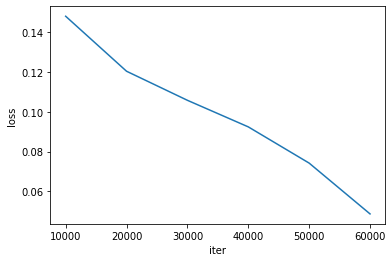

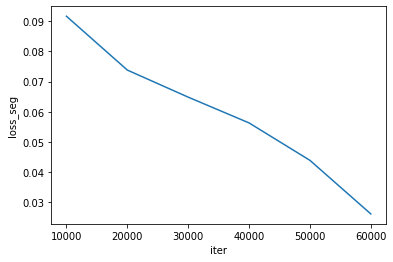

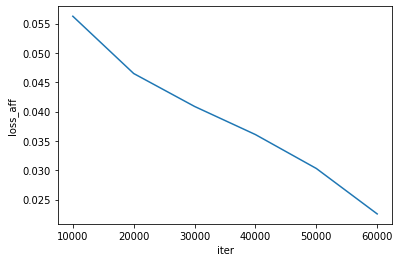

iter:60010, loss:0.0724, loss_seg:0.0446, loss_aff:0.0279
iter:60020, loss:0.0402, loss_seg:0.0197, loss_aff:0.0205
iter:60030, loss:0.0460, loss_seg:0.0221, loss_aff:0.0239
iter:60040, loss:0.0580, loss_seg:0.0345, loss_aff:0.0235
iter:60050, loss:0.0712, loss_seg:0.0306, loss_aff:0.0406
iter:60060, loss:0.0388, loss_seg:0.0194, loss_aff:0.0194
iter:60070, loss:0.0434, loss_seg:0.0192, loss_aff:0.0242
iter:60080, loss:0.0407, loss_seg:0.0184, loss_aff:0.0223
iter:60090, loss:0.0243, loss_seg:0.0113, loss_aff:0.0130
iter:60100, loss:0.0288, loss_seg:0.0146, loss_aff:0.0142
iter:60110, loss:0.0344, loss_seg:0.0150, loss_aff:0.0193
iter:60120, loss:0.0454, loss_seg:0.0188, loss_aff:0.0266
iter:60130, loss:0.0596, loss_seg:0.0292, loss_aff:0.0304
iter:60140, loss:0.0349, loss_seg:0.0154, loss_aff:0.0195
iter:60150, loss:0.0655, loss_seg:0.0400, loss_aff:0.0255
iter:60160, loss:0.0258, loss_seg:0.0109, loss_aff:0.0149
iter:60170, loss:0.0249, loss_seg:0.0118, loss_aff:0.0131
iter:60180, lo

iter:61430, loss:0.0247, loss_seg:0.0140, loss_aff:0.0108
iter:61440, loss:0.0225, loss_seg:0.0089, loss_aff:0.0136
iter:61450, loss:0.0223, loss_seg:0.0113, loss_aff:0.0110
iter:61460, loss:0.0323, loss_seg:0.0158, loss_aff:0.0165
iter:61470, loss:0.0304, loss_seg:0.0158, loss_aff:0.0146
iter:61480, loss:0.0324, loss_seg:0.0148, loss_aff:0.0176
iter:61490, loss:0.0574, loss_seg:0.0428, loss_aff:0.0147
iter:61500, loss:0.0491, loss_seg:0.0222, loss_aff:0.0269
iter:61510, loss:0.0206, loss_seg:0.0095, loss_aff:0.0111
iter:61520, loss:0.0324, loss_seg:0.0207, loss_aff:0.0117
iter:61530, loss:0.0243, loss_seg:0.0085, loss_aff:0.0157
iter:61540, loss:0.0211, loss_seg:0.0093, loss_aff:0.0118
iter:61550, loss:0.0309, loss_seg:0.0161, loss_aff:0.0148
iter:61560, loss:0.0404, loss_seg:0.0204, loss_aff:0.0200
iter:61570, loss:0.0335, loss_seg:0.0124, loss_aff:0.0211
iter:61580, loss:0.0267, loss_seg:0.0103, loss_aff:0.0164
iter:61590, loss:0.0280, loss_seg:0.0101, loss_aff:0.0178
iter:61600, lo

iter:62820, loss:0.0235, loss_seg:0.0106, loss_aff:0.0129
iter:62830, loss:0.0181, loss_seg:0.0075, loss_aff:0.0106
iter:62840, loss:0.0424, loss_seg:0.0290, loss_aff:0.0134
iter:62850, loss:0.0403, loss_seg:0.0181, loss_aff:0.0223
iter:62860, loss:0.0255, loss_seg:0.0108, loss_aff:0.0146
iter:62870, loss:0.0289, loss_seg:0.0128, loss_aff:0.0161
iter:62880, loss:0.0499, loss_seg:0.0239, loss_aff:0.0260
iter:62890, loss:0.0540, loss_seg:0.0246, loss_aff:0.0294
iter:62900, loss:0.0211, loss_seg:0.0087, loss_aff:0.0124
iter:62910, loss:0.0301, loss_seg:0.0127, loss_aff:0.0174
iter:62920, loss:0.0262, loss_seg:0.0107, loss_aff:0.0155
iter:62930, loss:0.0508, loss_seg:0.0311, loss_aff:0.0197
iter:62940, loss:0.0239, loss_seg:0.0090, loss_aff:0.0149
iter:62950, loss:0.0469, loss_seg:0.0225, loss_aff:0.0245
iter:62960, loss:0.0460, loss_seg:0.0246, loss_aff:0.0214
iter:62970, loss:0.0390, loss_seg:0.0204, loss_aff:0.0186
iter:62980, loss:0.0376, loss_seg:0.0179, loss_aff:0.0197
iter:62990, lo

iter:64210, loss:0.0307, loss_seg:0.0151, loss_aff:0.0156
iter:64220, loss:0.0367, loss_seg:0.0200, loss_aff:0.0166
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:64230, loss:0.0259, loss_seg:0.0115, loss_aff:0.0144
iter:64240, loss:0.0343, loss_seg:0.0202, loss_aff:0.0141
iter:64250, loss:0.0453, loss_seg:0.0274, loss_aff:0.0179
iter:64260, loss:0.0234, loss_seg:0.0099, loss_aff:0.0135
iter:64270, loss:0.0201, loss_seg:0.0088, loss_aff:0.0112
iter:64280, loss:0.0287, loss_seg:0.0128, loss_aff:0.0159
iter:64290, loss:0.0324, loss_seg:0.0132, loss_aff:0.0192
iter:64300, loss:0.0357, loss_seg:0.0186, loss_aff:0.0171
iter:64310, loss:0.0442, loss_seg:0.0202, loss_aff:0.0239
iter:64320, loss:0.0326, loss_seg:0.0141, loss_aff:0.0185
iter:64330, loss:0.0575, loss_seg:0.0329, loss_aff:0.0245
iter:64340, loss:0.0259, loss_seg:0.0114, loss_aff:0.0145
iter:64350, loss:0.0348, loss_seg:0.0190, loss_aff

iter:65600, loss:0.0220, loss_seg:0.0089, loss_aff:0.0132
iter:65610, loss:0.0197, loss_seg:0.0088, loss_aff:0.0109
iter:65620, loss:0.0251, loss_seg:0.0114, loss_aff:0.0137
iter:65630, loss:0.0233, loss_seg:0.0109, loss_aff:0.0123
iter:65640, loss:0.0296, loss_seg:0.0113, loss_aff:0.0183
iter:65650, loss:0.0343, loss_seg:0.0139, loss_aff:0.0204
iter:65660, loss:0.0229, loss_seg:0.0102, loss_aff:0.0127
iter:65670, loss:0.0286, loss_seg:0.0141, loss_aff:0.0145
iter:65680, loss:0.0213, loss_seg:0.0085, loss_aff:0.0128
iter:65690, loss:0.0427, loss_seg:0.0191, loss_aff:0.0236
iter:65700, loss:0.0392, loss_seg:0.0221, loss_aff:0.0171
iter:65710, loss:0.0392, loss_seg:0.0170, loss_aff:0.0222
iter:65720, loss:0.0407, loss_seg:0.0216, loss_aff:0.0191
iter:65730, loss:0.0258, loss_seg:0.0128, loss_aff:0.0130
iter:65740, loss:0.0216, loss_seg:0.0088, loss_aff:0.0128
iter:65750, loss:0.0284, loss_seg:0.0121, loss_aff:0.0164
iter:65760, loss:0.0265, loss_seg:0.0105, loss_aff:0.0160
iter:65770, lo

iter:66970, loss:0.0281, loss_seg:0.0110, loss_aff:0.0171
iter:66980, loss:0.0351, loss_seg:0.0155, loss_aff:0.0196
iter:66990, loss:0.0227, loss_seg:0.0095, loss_aff:0.0132
iter:67000, loss:0.0209, loss_seg:0.0090, loss_aff:0.0120
iter:67010, loss:0.0474, loss_seg:0.0314, loss_aff:0.0160
iter:67020, loss:0.0393, loss_seg:0.0184, loss_aff:0.0209
iter:67030, loss:0.0470, loss_seg:0.0234, loss_aff:0.0236
iter:67040, loss:0.0252, loss_seg:0.0103, loss_aff:0.0149
iter:67050, loss:0.0283, loss_seg:0.0122, loss_aff:0.0161
iter:67060, loss:0.0275, loss_seg:0.0156, loss_aff:0.0119
iter:67070, loss:0.0361, loss_seg:0.0158, loss_aff:0.0203
iter:67080, loss:0.0509, loss_seg:0.0274, loss_aff:0.0235
iter:67090, loss:0.0508, loss_seg:0.0258, loss_aff:0.0250
iter:67100, loss:0.0211, loss_seg:0.0101, loss_aff:0.0110
iter:67110, loss:0.0358, loss_seg:0.0159, loss_aff:0.0200
iter:67120, loss:0.0327, loss_seg:0.0147, loss_aff:0.0179
iter:67130, loss:0.0430, loss_seg:0.0211, loss_aff:0.0218
iter:67140, lo

iter:68360, loss:0.0232, loss_seg:0.0096, loss_aff:0.0136
iter:68370, loss:0.0121, loss_seg:0.0042, loss_aff:0.0079
iter:68380, loss:0.0352, loss_seg:0.0153, loss_aff:0.0199
iter:68390, loss:0.0193, loss_seg:0.0088, loss_aff:0.0106
iter:68400, loss:0.0136, loss_seg:0.0050, loss_aff:0.0086
iter:68410, loss:0.0488, loss_seg:0.0247, loss_aff:0.0241
iter:68420, loss:0.0153, loss_seg:0.0051, loss_aff:0.0102
iter:68430, loss:0.0202, loss_seg:0.0087, loss_aff:0.0114
iter:68440, loss:0.0222, loss_seg:0.0139, loss_aff:0.0083
iter:68450, loss:0.0238, loss_seg:0.0107, loss_aff:0.0131
iter:68460, loss:0.0237, loss_seg:0.0088, loss_aff:0.0149
iter:68470, loss:0.0148, loss_seg:0.0070, loss_aff:0.0078
iter:68480, loss:0.0341, loss_seg:0.0134, loss_aff:0.0207
iter:68490, loss:0.0215, loss_seg:0.0071, loss_aff:0.0144
iter:68500, loss:0.0173, loss_seg:0.0080, loss_aff:0.0093
iter:68510, loss:0.0115, loss_seg:0.0035, loss_aff:0.0080
iter:68520, loss:0.0370, loss_seg:0.0228, loss_aff:0.0142
iter:68530, lo

Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:69750, loss:0.0231, loss_seg:0.0115, loss_aff:0.0116
iter:69760, loss:0.0232, loss_seg:0.0109, loss_aff:0.0124
iter:69770, loss:0.0378, loss_seg:0.0194, loss_aff:0.0184
iter:69780, loss:0.0306, loss_seg:0.0143, loss_aff:0.0163
iter:69790, loss:0.0329, loss_seg:0.0139, loss_aff:0.0190
iter:69800, loss:0.0316, loss_seg:0.0152, loss_aff:0.0164
iter:69810, loss:0.0170, loss_seg:0.0082, loss_aff:0.0088
iter:69820, loss:0.0198, loss_seg:0.0077, loss_aff:0.0121
iter:69830, loss:0.0204, loss_seg:0.0071, loss_aff:0.0133
iter:69840, loss:0.0197, loss_seg:0.0071, loss_aff:0.0127
iter:69850, loss:0.0164, loss_seg:0.0061, loss_aff:0.0103
iter:69860, loss:0.0274, loss_seg:0.0120, loss_aff:0.0154
iter:69870, loss:0.0273, loss_seg:0.0134, loss_aff:0.0139
iter:69880, loss:0.0159, loss_seg:0.0055, loss_aff:0.0104
iter:69890, loss:0.0233, loss_seg:0.0096, loss_aff

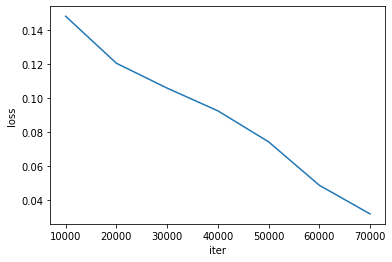

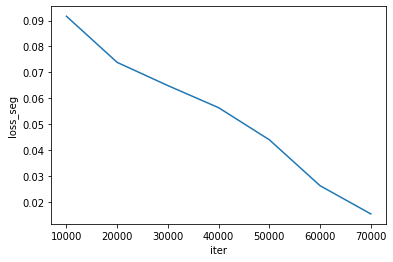

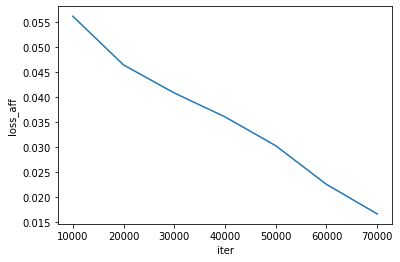

iter:70010, loss:0.0190, loss_seg:0.0075, loss_aff:0.0115
iter:70020, loss:0.0302, loss_seg:0.0106, loss_aff:0.0196
iter:70030, loss:0.0353, loss_seg:0.0169, loss_aff:0.0184
iter:70040, loss:0.0251, loss_seg:0.0117, loss_aff:0.0134
iter:70050, loss:0.0142, loss_seg:0.0057, loss_aff:0.0084
iter:70060, loss:0.0216, loss_seg:0.0096, loss_aff:0.0120
iter:70070, loss:0.0566, loss_seg:0.0286, loss_aff:0.0280
iter:70080, loss:0.0308, loss_seg:0.0150, loss_aff:0.0159
iter:70090, loss:0.0184, loss_seg:0.0085, loss_aff:0.0099
iter:70100, loss:0.0359, loss_seg:0.0194, loss_aff:0.0165
iter:70110, loss:0.0457, loss_seg:0.0256, loss_aff:0.0202
iter:70120, loss:0.0218, loss_seg:0.0090, loss_aff:0.0128
iter:70130, loss:0.0256, loss_seg:0.0144, loss_aff:0.0112
iter:70140, loss:0.0532, loss_seg:0.0230, loss_aff:0.0302
iter:70150, loss:0.0399, loss_seg:0.0173, loss_aff:0.0226
iter:70160, loss:0.0197, loss_seg:0.0077, loss_aff:0.0120
iter:70170, loss:0.0219, loss_seg:0.0082, loss_aff:0.0138
iter:70180, lo

iter:71400, loss:0.0206, loss_seg:0.0068, loss_aff:0.0138
iter:71410, loss:0.0346, loss_seg:0.0156, loss_aff:0.0191
iter:71420, loss:0.0355, loss_seg:0.0151, loss_aff:0.0205
iter:71430, loss:0.0219, loss_seg:0.0097, loss_aff:0.0122
iter:71440, loss:0.0317, loss_seg:0.0154, loss_aff:0.0163
iter:71450, loss:0.0358, loss_seg:0.0166, loss_aff:0.0192
iter:71460, loss:0.0186, loss_seg:0.0076, loss_aff:0.0110
iter:71470, loss:0.0252, loss_seg:0.0101, loss_aff:0.0151
iter:71480, loss:0.0189, loss_seg:0.0080, loss_aff:0.0109
iter:71490, loss:0.0195, loss_seg:0.0087, loss_aff:0.0108
iter:71500, loss:0.0214, loss_seg:0.0096, loss_aff:0.0119
iter:71510, loss:0.0252, loss_seg:0.0107, loss_aff:0.0145
iter:71520, loss:0.0105, loss_seg:0.0044, loss_aff:0.0061
iter:71530, loss:0.0421, loss_seg:0.0205, loss_aff:0.0216
iter:71540, loss:0.0314, loss_seg:0.0151, loss_aff:0.0163
iter:71550, loss:0.0204, loss_seg:0.0087, loss_aff:0.0118
iter:71560, loss:0.0217, loss_seg:0.0084, loss_aff:0.0133
iter:71570, lo

iter:72770, loss:0.0109, loss_seg:0.0046, loss_aff:0.0063
iter:72780, loss:0.0463, loss_seg:0.0289, loss_aff:0.0174
iter:72790, loss:0.0208, loss_seg:0.0081, loss_aff:0.0127
iter:72800, loss:0.0218, loss_seg:0.0105, loss_aff:0.0113
iter:72810, loss:0.0151, loss_seg:0.0046, loss_aff:0.0105
iter:72820, loss:0.0201, loss_seg:0.0060, loss_aff:0.0142
iter:72830, loss:0.0113, loss_seg:0.0044, loss_aff:0.0069
iter:72840, loss:0.0138, loss_seg:0.0052, loss_aff:0.0087
iter:72850, loss:0.0097, loss_seg:0.0032, loss_aff:0.0065
iter:72860, loss:0.0315, loss_seg:0.0145, loss_aff:0.0171
iter:72870, loss:0.0217, loss_seg:0.0077, loss_aff:0.0139
iter:72880, loss:0.0184, loss_seg:0.0075, loss_aff:0.0109
iter:72890, loss:0.0120, loss_seg:0.0054, loss_aff:0.0066
iter:72900, loss:0.0336, loss_seg:0.0138, loss_aff:0.0198
iter:72910, loss:0.0197, loss_seg:0.0087, loss_aff:0.0110
iter:72920, loss:0.0152, loss_seg:0.0048, loss_aff:0.0104
iter:72930, loss:0.0179, loss_seg:0.0063, loss_aff:0.0116
iter:72940, lo

iter:74190, loss:0.0220, loss_seg:0.0093, loss_aff:0.0127
iter:74200, loss:0.0231, loss_seg:0.0098, loss_aff:0.0133
iter:74210, loss:0.0494, loss_seg:0.0218, loss_aff:0.0275
iter:74220, loss:0.0259, loss_seg:0.0108, loss_aff:0.0150
iter:74230, loss:0.0169, loss_seg:0.0065, loss_aff:0.0104
iter:74240, loss:0.0218, loss_seg:0.0074, loss_aff:0.0144
iter:74250, loss:0.0205, loss_seg:0.0072, loss_aff:0.0133
iter:74260, loss:0.0443, loss_seg:0.0272, loss_aff:0.0171
iter:74270, loss:0.0266, loss_seg:0.0146, loss_aff:0.0120
iter:74280, loss:0.0297, loss_seg:0.0113, loss_aff:0.0183
iter:74290, loss:0.0205, loss_seg:0.0074, loss_aff:0.0130
iter:74300, loss:0.0169, loss_seg:0.0059, loss_aff:0.0110
iter:74310, loss:0.0173, loss_seg:0.0073, loss_aff:0.0100
iter:74320, loss:0.0155, loss_seg:0.0052, loss_aff:0.0103
iter:74330, loss:0.0341, loss_seg:0.0154, loss_aff:0.0187
iter:74340, loss:0.0137, loss_seg:0.0057, loss_aff:0.0080
iter:74350, loss:0.0126, loss_seg:0.0056, loss_aff:0.0070
iter:74360, lo

iter:75560, loss:0.0225, loss_seg:0.0085, loss_aff:0.0140
iter:75570, loss:0.0105, loss_seg:0.0035, loss_aff:0.0070
iter:75580, loss:0.1162, loss_seg:0.0998, loss_aff:0.0164
iter:75590, loss:0.0112, loss_seg:0.0038, loss_aff:0.0074
iter:75600, loss:0.0219, loss_seg:0.0068, loss_aff:0.0151
iter:75610, loss:0.0415, loss_seg:0.0197, loss_aff:0.0217
iter:75620, loss:0.0173, loss_seg:0.0086, loss_aff:0.0087
iter:75630, loss:0.0148, loss_seg:0.0052, loss_aff:0.0096
iter:75640, loss:0.0240, loss_seg:0.0099, loss_aff:0.0142
iter:75650, loss:0.0219, loss_seg:0.0077, loss_aff:0.0143
iter:75660, loss:0.0189, loss_seg:0.0091, loss_aff:0.0098
iter:75670, loss:0.0146, loss_seg:0.0053, loss_aff:0.0093
iter:75680, loss:0.0087, loss_seg:0.0027, loss_aff:0.0060
iter:75690, loss:0.0287, loss_seg:0.0110, loss_aff:0.0178
iter:75700, loss:0.0364, loss_seg:0.0156, loss_aff:0.0208
iter:75710, loss:0.0216, loss_seg:0.0079, loss_aff:0.0137
iter:75720, loss:0.0153, loss_seg:0.0055, loss_aff:0.0098
iter:75730, lo

iter:76950, loss:0.0188, loss_seg:0.0067, loss_aff:0.0121
iter:76960, loss:0.0179, loss_seg:0.0072, loss_aff:0.0107
iter:76970, loss:0.0083, loss_seg:0.0030, loss_aff:0.0053
iter:76980, loss:0.0281, loss_seg:0.0093, loss_aff:0.0188
iter:76990, loss:0.0172, loss_seg:0.0097, loss_aff:0.0074
iter:77000, loss:0.0124, loss_seg:0.0051, loss_aff:0.0073
iter:77010, loss:0.0341, loss_seg:0.0165, loss_aff:0.0176
iter:77020, loss:0.0082, loss_seg:0.0035, loss_aff:0.0047
iter:77030, loss:0.0215, loss_seg:0.0084, loss_aff:0.0131
iter:77040, loss:0.0210, loss_seg:0.0080, loss_aff:0.0130
iter:77050, loss:0.0202, loss_seg:0.0084, loss_aff:0.0118
iter:77060, loss:0.0152, loss_seg:0.0054, loss_aff:0.0097
iter:77070, loss:0.0109, loss_seg:0.0036, loss_aff:0.0073
iter:77080, loss:0.0165, loss_seg:0.0066, loss_aff:0.0099
iter:77090, loss:0.0283, loss_seg:0.0137, loss_aff:0.0146
iter:77100, loss:0.0154, loss_seg:0.0064, loss_aff:0.0090
iter:77110, loss:0.0152, loss_seg:0.0052, loss_aff:0.0100
iter:77120, lo

iter:78340, loss:0.0279, loss_seg:0.0113, loss_aff:0.0166
iter:78350, loss:0.0333, loss_seg:0.0120, loss_aff:0.0213
iter:78360, loss:0.0168, loss_seg:0.0072, loss_aff:0.0096
iter:78370, loss:0.0268, loss_seg:0.0115, loss_aff:0.0153
iter:78380, loss:0.0366, loss_seg:0.0214, loss_aff:0.0151
iter:78390, loss:0.0134, loss_seg:0.0059, loss_aff:0.0075
iter:78400, loss:0.0216, loss_seg:0.0079, loss_aff:0.0136
iter:78410, loss:0.0236, loss_seg:0.0110, loss_aff:0.0126
iter:78420, loss:0.0132, loss_seg:0.0057, loss_aff:0.0076
iter:78430, loss:0.0115, loss_seg:0.0046, loss_aff:0.0069
iter:78440, loss:0.0260, loss_seg:0.0104, loss_aff:0.0155
iter:78450, loss:0.0171, loss_seg:0.0069, loss_aff:0.0103
iter:78460, loss:0.0285, loss_seg:0.0135, loss_aff:0.0151
iter:78470, loss:0.0250, loss_seg:0.0091, loss_aff:0.0159
iter:78480, loss:0.0385, loss_seg:0.0248, loss_aff:0.0137
iter:78490, loss:0.0204, loss_seg:0.0089, loss_aff:0.0115
iter:78500, loss:0.0147, loss_seg:0.0051, loss_aff:0.0096
iter:78510, lo

iter:79760, loss:0.0158, loss_seg:0.0061, loss_aff:0.0097
iter:79770, loss:0.0136, loss_seg:0.0048, loss_aff:0.0087
iter:79780, loss:0.0157, loss_seg:0.0061, loss_aff:0.0096
iter:79790, loss:0.0221, loss_seg:0.0096, loss_aff:0.0125
iter:79800, loss:0.0105, loss_seg:0.0044, loss_aff:0.0062
iter:79810, loss:0.0167, loss_seg:0.0058, loss_aff:0.0109
iter:79820, loss:0.0254, loss_seg:0.0113, loss_aff:0.0141
iter:79830, loss:0.0186, loss_seg:0.0062, loss_aff:0.0124
iter:79840, loss:0.0223, loss_seg:0.0096, loss_aff:0.0127
iter:79850, loss:0.0112, loss_seg:0.0037, loss_aff:0.0075
iter:79860, loss:0.0120, loss_seg:0.0058, loss_aff:0.0063
iter:79870, loss:0.0085, loss_seg:0.0036, loss_aff:0.0049
iter:79880, loss:0.0226, loss_seg:0.0099, loss_aff:0.0128
iter:79890, loss:0.0094, loss_seg:0.0032, loss_aff:0.0062
iter:79900, loss:0.0165, loss_seg:0.0067, loss_aff:0.0098
iter:79910, loss:0.0179, loss_seg:0.0069, loss_aff:0.0109
iter:79920, loss:0.0324, loss_seg:0.0199, loss_aff:0.0125
iter:79930, lo

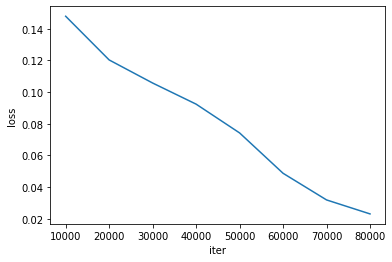

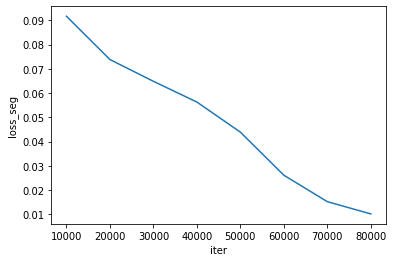

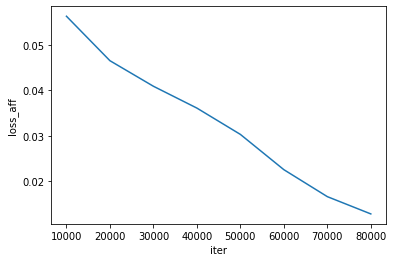

iter:80010, loss:0.0153, loss_seg:0.0053, loss_aff:0.0101
iter:80020, loss:0.0169, loss_seg:0.0062, loss_aff:0.0107
iter:80030, loss:0.0146, loss_seg:0.0061, loss_aff:0.0086
iter:80040, loss:0.0152, loss_seg:0.0063, loss_aff:0.0090
iter:80050, loss:0.0229, loss_seg:0.0076, loss_aff:0.0153
iter:80060, loss:0.0249, loss_seg:0.0099, loss_aff:0.0150
iter:80070, loss:0.0126, loss_seg:0.0052, loss_aff:0.0074
iter:80080, loss:0.0148, loss_seg:0.0049, loss_aff:0.0099
iter:80090, loss:0.0129, loss_seg:0.0044, loss_aff:0.0085
iter:80100, loss:0.0086, loss_seg:0.0024, loss_aff:0.0061
iter:80110, loss:0.0262, loss_seg:0.0135, loss_aff:0.0126
iter:80120, loss:0.0301, loss_seg:0.0180, loss_aff:0.0121
iter:80130, loss:0.0176, loss_seg:0.0061, loss_aff:0.0115
iter:80140, loss:0.0182, loss_seg:0.0060, loss_aff:0.0122
iter:80150, loss:0.0177, loss_seg:0.0066, loss_aff:0.0111
iter:80160, loss:0.0481, loss_seg:0.0357, loss_aff:0.0124
iter:80170, loss:0.0104, loss_seg:0.0041, loss_aff:0.0063
iter:80180, lo

iter:81380, loss:0.0228, loss_seg:0.0119, loss_aff:0.0109
iter:81390, loss:0.0589, loss_seg:0.0244, loss_aff:0.0345
iter:81400, loss:0.0237, loss_seg:0.0110, loss_aff:0.0127
iter:81410, loss:0.0234, loss_seg:0.0113, loss_aff:0.0121
iter:81420, loss:0.0241, loss_seg:0.0132, loss_aff:0.0109
iter:81430, loss:0.0262, loss_seg:0.0137, loss_aff:0.0125
iter:81440, loss:0.0292, loss_seg:0.0141, loss_aff:0.0151
iter:81450, loss:0.0164, loss_seg:0.0064, loss_aff:0.0099
iter:81460, loss:0.0355, loss_seg:0.0158, loss_aff:0.0196
iter:81470, loss:0.0195, loss_seg:0.0081, loss_aff:0.0114
iter:81480, loss:0.0125, loss_seg:0.0040, loss_aff:0.0085
iter:81490, loss:0.0226, loss_seg:0.0093, loss_aff:0.0134
iter:81500, loss:0.0180, loss_seg:0.0076, loss_aff:0.0104
iter:81510, loss:0.0177, loss_seg:0.0072, loss_aff:0.0105
iter:81520, loss:0.0246, loss_seg:0.0106, loss_aff:0.0140
iter:81530, loss:0.0182, loss_seg:0.0054, loss_aff:0.0128
iter:81540, loss:0.0300, loss_seg:0.0103, loss_aff:0.0197
iter:81550, lo

iter:82770, loss:0.0121, loss_seg:0.0043, loss_aff:0.0078
iter:82780, loss:0.0179, loss_seg:0.0060, loss_aff:0.0118
iter:82790, loss:0.0152, loss_seg:0.0066, loss_aff:0.0086
iter:82800, loss:0.0139, loss_seg:0.0055, loss_aff:0.0084
iter:82810, loss:0.0251, loss_seg:0.0141, loss_aff:0.0110
iter:82820, loss:0.0146, loss_seg:0.0056, loss_aff:0.0089
iter:82830, loss:0.0230, loss_seg:0.0126, loss_aff:0.0104
iter:82840, loss:0.0152, loss_seg:0.0050, loss_aff:0.0101
iter:82850, loss:0.0083, loss_seg:0.0031, loss_aff:0.0051
iter:82860, loss:0.0090, loss_seg:0.0027, loss_aff:0.0063
iter:82870, loss:0.0176, loss_seg:0.0069, loss_aff:0.0106
iter:82880, loss:0.0124, loss_seg:0.0054, loss_aff:0.0070
iter:82890, loss:0.0227, loss_seg:0.0090, loss_aff:0.0137
iter:82900, loss:0.0099, loss_seg:0.0039, loss_aff:0.0060
iter:82910, loss:0.0111, loss_seg:0.0045, loss_aff:0.0066
iter:82920, loss:0.0111, loss_seg:0.0033, loss_aff:0.0078
iter:82930, loss:0.0083, loss_seg:0.0029, loss_aff:0.0054
iter:82940, lo

iter:84140, loss:0.0147, loss_seg:0.0059, loss_aff:0.0087
iter:84150, loss:0.0207, loss_seg:0.0069, loss_aff:0.0138
iter:84160, loss:0.0185, loss_seg:0.0095, loss_aff:0.0091
iter:84170, loss:0.0177, loss_seg:0.0067, loss_aff:0.0110
iter:84180, loss:0.0310, loss_seg:0.0122, loss_aff:0.0188
iter:84190, loss:0.0117, loss_seg:0.0038, loss_aff:0.0079
iter:84200, loss:0.0159, loss_seg:0.0066, loss_aff:0.0093
iter:84210, loss:0.0355, loss_seg:0.0176, loss_aff:0.0179
iter:84220, loss:0.0098, loss_seg:0.0036, loss_aff:0.0062
iter:84230, loss:0.0276, loss_seg:0.0169, loss_aff:0.0108
iter:84240, loss:0.0125, loss_seg:0.0045, loss_aff:0.0079
iter:84250, loss:0.0135, loss_seg:0.0053, loss_aff:0.0082
iter:84260, loss:0.0121, loss_seg:0.0047, loss_aff:0.0074
iter:84270, loss:0.0082, loss_seg:0.0026, loss_aff:0.0057
iter:84280, loss:0.0207, loss_seg:0.0076, loss_aff:0.0131
iter:84290, loss:0.0190, loss_seg:0.0063, loss_aff:0.0127
iter:84300, loss:0.0199, loss_seg:0.0074, loss_aff:0.0125
iter:84310, lo

iter:85560, loss:0.0103, loss_seg:0.0048, loss_aff:0.0055
iter:85570, loss:0.0137, loss_seg:0.0044, loss_aff:0.0093
iter:85580, loss:0.0091, loss_seg:0.0031, loss_aff:0.0060
iter:85590, loss:0.0167, loss_seg:0.0063, loss_aff:0.0104
iter:85600, loss:0.0196, loss_seg:0.0071, loss_aff:0.0125
iter:85610, loss:0.0122, loss_seg:0.0048, loss_aff:0.0073
iter:85620, loss:0.0254, loss_seg:0.0109, loss_aff:0.0145
iter:85630, loss:0.0163, loss_seg:0.0053, loss_aff:0.0110
iter:85640, loss:0.0138, loss_seg:0.0052, loss_aff:0.0086
iter:85650, loss:0.0178, loss_seg:0.0069, loss_aff:0.0109
iter:85660, loss:0.0276, loss_seg:0.0128, loss_aff:0.0148
iter:85670, loss:0.0128, loss_seg:0.0045, loss_aff:0.0083
iter:85680, loss:0.0207, loss_seg:0.0072, loss_aff:0.0135
iter:85690, loss:0.0129, loss_seg:0.0045, loss_aff:0.0084
iter:85700, loss:0.0077, loss_seg:0.0029, loss_aff:0.0048
iter:85710, loss:0.0174, loss_seg:0.0059, loss_aff:0.0115
iter:85720, loss:0.0146, loss_seg:0.0050, loss_aff:0.0096
iter:85730, lo

iter:86950, loss:0.0193, loss_seg:0.0078, loss_aff:0.0115
iter:86960, loss:0.0205, loss_seg:0.0097, loss_aff:0.0108
iter:86970, loss:0.0102, loss_seg:0.0033, loss_aff:0.0069
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:86980, loss:0.0104, loss_seg:0.0033, loss_aff:0.0071
iter:86990, loss:0.0121, loss_seg:0.0044, loss_aff:0.0077
iter:87000, loss:0.0118, loss_seg:0.0032, loss_aff:0.0086
iter:87010, loss:0.0321, loss_seg:0.0184, loss_aff:0.0138
iter:87020, loss:0.0131, loss_seg:0.0050, loss_aff:0.0080
iter:87030, loss:0.0157, loss_seg:0.0058, loss_aff:0.0099
iter:87040, loss:0.0139, loss_seg:0.0053, loss_aff:0.0087
iter:87050, loss:0.0219, loss_seg:0.0110, loss_aff:0.0109
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:87060, loss:0.0123, loss_seg:0.0046, loss_aff:0.0077
iter:87070, loss:0.0131, loss

iter:88300, loss:0.0055, loss_seg:0.0018, loss_aff:0.0037
iter:88310, loss:0.0262, loss_seg:0.0096, loss_aff:0.0166
iter:88320, loss:0.0196, loss_seg:0.0073, loss_aff:0.0122
iter:88330, loss:0.0143, loss_seg:0.0059, loss_aff:0.0085
iter:88340, loss:0.0099, loss_seg:0.0038, loss_aff:0.0061
iter:88350, loss:0.0110, loss_seg:0.0039, loss_aff:0.0071
iter:88360, loss:0.0161, loss_seg:0.0051, loss_aff:0.0110
iter:88370, loss:0.0086, loss_seg:0.0028, loss_aff:0.0058
iter:88380, loss:0.0097, loss_seg:0.0036, loss_aff:0.0061
iter:88390, loss:0.0075, loss_seg:0.0032, loss_aff:0.0043
iter:88400, loss:0.0178, loss_seg:0.0084, loss_aff:0.0094
iter:88410, loss:0.0149, loss_seg:0.0054, loss_aff:0.0095
iter:88420, loss:0.0087, loss_seg:0.0033, loss_aff:0.0055
iter:88430, loss:0.0156, loss_seg:0.0062, loss_aff:0.0094
iter:88440, loss:0.0162, loss_seg:0.0063, loss_aff:0.0099
iter:88450, loss:0.0140, loss_seg:0.0052, loss_aff:0.0087
iter:88460, loss:0.0108, loss_seg:0.0040, loss_aff:0.0068
iter:88470, lo

iter:89720, loss:0.0084, loss_seg:0.0037, loss_aff:0.0047
iter:89730, loss:0.0095, loss_seg:0.0032, loss_aff:0.0063
iter:89740, loss:0.0109, loss_seg:0.0045, loss_aff:0.0065
iter:89750, loss:0.0091, loss_seg:0.0028, loss_aff:0.0063
iter:89760, loss:0.0098, loss_seg:0.0032, loss_aff:0.0066
iter:89770, loss:0.0141, loss_seg:0.0052, loss_aff:0.0089
iter:89780, loss:0.0078, loss_seg:0.0028, loss_aff:0.0050
iter:89790, loss:0.0154, loss_seg:0.0058, loss_aff:0.0096
iter:89800, loss:0.0103, loss_seg:0.0036, loss_aff:0.0067
iter:89810, loss:0.0194, loss_seg:0.0069, loss_aff:0.0126
iter:89820, loss:0.0066, loss_seg:0.0025, loss_aff:0.0042
iter:89830, loss:0.0064, loss_seg:0.0026, loss_aff:0.0038
iter:89840, loss:0.0067, loss_seg:0.0025, loss_aff:0.0041
iter:89850, loss:0.0106, loss_seg:0.0045, loss_aff:0.0061
iter:89860, loss:0.0091, loss_seg:0.0029, loss_aff:0.0062
iter:89870, loss:0.0126, loss_seg:0.0053, loss_aff:0.0074
iter:89880, loss:0.0109, loss_seg:0.0030, loss_aff:0.0079
iter:89890, lo

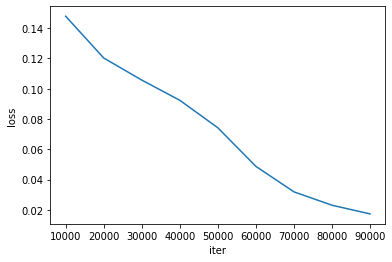

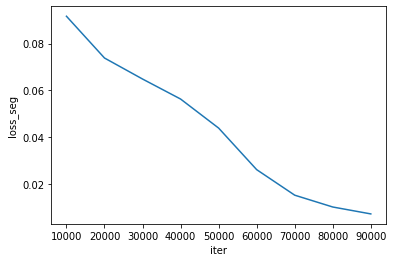

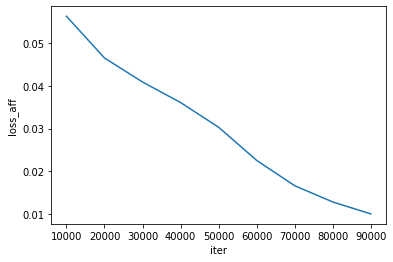

iter:90010, loss:0.0118, loss_seg:0.0042, loss_aff:0.0075
iter:90020, loss:0.0146, loss_seg:0.0055, loss_aff:0.0090
iter:90030, loss:0.0092, loss_seg:0.0029, loss_aff:0.0063
iter:90040, loss:0.0140, loss_seg:0.0048, loss_aff:0.0092
iter:90050, loss:0.0139, loss_seg:0.0055, loss_aff:0.0084
iter:90060, loss:0.0145, loss_seg:0.0058, loss_aff:0.0087
iter:90070, loss:0.0140, loss_seg:0.0041, loss_aff:0.0099
iter:90080, loss:0.0066, loss_seg:0.0025, loss_aff:0.0041
iter:90090, loss:0.0072, loss_seg:0.0020, loss_aff:0.0053
iter:90100, loss:0.0087, loss_seg:0.0035, loss_aff:0.0052
iter:90110, loss:0.0155, loss_seg:0.0085, loss_aff:0.0070
iter:90120, loss:0.0499, loss_seg:0.0360, loss_aff:0.0139
iter:90130, loss:0.0076, loss_seg:0.0020, loss_aff:0.0056
iter:90140, loss:0.0206, loss_seg:0.0108, loss_aff:0.0099
iter:90150, loss:0.0140, loss_seg:0.0041, loss_aff:0.0099
iter:90160, loss:0.0188, loss_seg:0.0066, loss_aff:0.0121
iter:90170, loss:0.0118, loss_seg:0.0040, loss_aff:0.0078
iter:90180, lo

iter:91380, loss:0.0151, loss_seg:0.0062, loss_aff:0.0089
iter:91390, loss:0.0214, loss_seg:0.0112, loss_aff:0.0101
iter:91400, loss:0.0119, loss_seg:0.0045, loss_aff:0.0074
iter:91410, loss:0.0519, loss_seg:0.0321, loss_aff:0.0198
iter:91420, loss:0.0169, loss_seg:0.0089, loss_aff:0.0080
iter:91430, loss:0.0152, loss_seg:0.0065, loss_aff:0.0087
iter:91440, loss:0.0112, loss_seg:0.0033, loss_aff:0.0079
iter:91450, loss:0.0216, loss_seg:0.0099, loss_aff:0.0117
iter:91460, loss:0.0162, loss_seg:0.0047, loss_aff:0.0115
iter:91470, loss:0.0095, loss_seg:0.0037, loss_aff:0.0058
iter:91480, loss:0.0123, loss_seg:0.0074, loss_aff:0.0048
iter:91490, loss:0.0096, loss_seg:0.0042, loss_aff:0.0055
iter:91500, loss:0.0284, loss_seg:0.0148, loss_aff:0.0136
iter:91510, loss:0.0221, loss_seg:0.0097, loss_aff:0.0124
iter:91520, loss:0.0119, loss_seg:0.0048, loss_aff:0.0071
iter:91530, loss:0.0239, loss_seg:0.0128, loss_aff:0.0111
iter:91540, loss:0.0170, loss_seg:0.0070, loss_aff:0.0100
iter:91550, lo

iter:92770, loss:0.0083, loss_seg:0.0032, loss_aff:0.0052
iter:92780, loss:0.0224, loss_seg:0.0071, loss_aff:0.0152
iter:92790, loss:0.0094, loss_seg:0.0032, loss_aff:0.0062
iter:92800, loss:0.0114, loss_seg:0.0051, loss_aff:0.0063
iter:92810, loss:0.0172, loss_seg:0.0084, loss_aff:0.0088
iter:92820, loss:0.0138, loss_seg:0.0045, loss_aff:0.0094
iter:92830, loss:0.0121, loss_seg:0.0050, loss_aff:0.0071
iter:92840, loss:0.0108, loss_seg:0.0032, loss_aff:0.0076
iter:92850, loss:0.0184, loss_seg:0.0070, loss_aff:0.0114
iter:92860, loss:0.0134, loss_seg:0.0046, loss_aff:0.0087
iter:92870, loss:0.0172, loss_seg:0.0068, loss_aff:0.0104
iter:92880, loss:0.0188, loss_seg:0.0104, loss_aff:0.0084
iter:92890, loss:0.0145, loss_seg:0.0078, loss_aff:0.0067
iter:92900, loss:0.0105, loss_seg:0.0047, loss_aff:0.0058
iter:92910, loss:0.0106, loss_seg:0.0038, loss_aff:0.0068
iter:92920, loss:0.0088, loss_seg:0.0034, loss_aff:0.0054
iter:92930, loss:0.0100, loss_seg:0.0032, loss_aff:0.0068
iter:92940, lo

iter:94190, loss:0.0283, loss_seg:0.0142, loss_aff:0.0140
iter:94200, loss:0.0264, loss_seg:0.0102, loss_aff:0.0162
iter:94210, loss:0.0108, loss_seg:0.0044, loss_aff:0.0064
iter:94220, loss:0.0174, loss_seg:0.0084, loss_aff:0.0090
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:94230, loss:0.0123, loss_seg:0.0051, loss_aff:0.0071
iter:94240, loss:0.0077, loss_seg:0.0026, loss_aff:0.0051
iter:94250, loss:0.0104, loss_seg:0.0038, loss_aff:0.0065
iter:94260, loss:0.0180, loss_seg:0.0060, loss_aff:0.0120
iter:94270, loss:0.0091, loss_seg:0.0035, loss_aff:0.0056
iter:94280, loss:0.0216, loss_seg:0.0080, loss_aff:0.0135
iter:94290, loss:0.0062, loss_seg:0.0025, loss_aff:0.0036
iter:94300, loss:0.0121, loss_seg:0.0038, loss_aff:0.0083
iter:94310, loss:0.0086, loss_seg:0.0024, loss_aff:0.0062
iter:94320, loss:0.0150, loss_seg:0.0062, loss_aff:0.0089
iter:94330, loss:0.0157, loss_seg:0.0062, loss_aff:

iter:95560, loss:0.0093, loss_seg:0.0038, loss_aff:0.0055
iter:95570, loss:0.0127, loss_seg:0.0048, loss_aff:0.0079
iter:95580, loss:0.0146, loss_seg:0.0044, loss_aff:0.0102
iter:95590, loss:0.0093, loss_seg:0.0034, loss_aff:0.0060
iter:95600, loss:0.0133, loss_seg:0.0051, loss_aff:0.0082
iter:95610, loss:0.0070, loss_seg:0.0024, loss_aff:0.0046
iter:95620, loss:0.0105, loss_seg:0.0043, loss_aff:0.0061
iter:95630, loss:0.0182, loss_seg:0.0078, loss_aff:0.0104
iter:95640, loss:0.0096, loss_seg:0.0042, loss_aff:0.0054
iter:95650, loss:0.0120, loss_seg:0.0041, loss_aff:0.0079
iter:95660, loss:0.0096, loss_seg:0.0036, loss_aff:0.0060
iter:95670, loss:0.0183, loss_seg:0.0068, loss_aff:0.0115
iter:95680, loss:0.0089, loss_seg:0.0024, loss_aff:0.0065
iter:95690, loss:0.0207, loss_seg:0.0068, loss_aff:0.0139
iter:95700, loss:0.0103, loss_seg:0.0036, loss_aff:0.0068
iter:95710, loss:0.0118, loss_seg:0.0046, loss_aff:0.0071
iter:95720, loss:0.0160, loss_seg:0.0059, loss_aff:0.0101
iter:95730, lo

iter:96950, loss:0.0067, loss_seg:0.0022, loss_aff:0.0045
iter:96960, loss:0.0079, loss_seg:0.0033, loss_aff:0.0047
iter:96970, loss:0.0059, loss_seg:0.0018, loss_aff:0.0041
iter:96980, loss:0.0126, loss_seg:0.0047, loss_aff:0.0078
iter:96990, loss:0.0067, loss_seg:0.0019, loss_aff:0.0049
iter:97000, loss:0.0307, loss_seg:0.0198, loss_aff:0.0109
iter:97010, loss:0.0115, loss_seg:0.0036, loss_aff:0.0079
iter:97020, loss:0.0110, loss_seg:0.0044, loss_aff:0.0067
iter:97030, loss:0.0115, loss_seg:0.0042, loss_aff:0.0073
iter:97040, loss:0.0108, loss_seg:0.0038, loss_aff:0.0069
iter:97050, loss:0.0049, loss_seg:0.0020, loss_aff:0.0029
iter:97060, loss:0.0172, loss_seg:0.0062, loss_aff:0.0110
iter:97070, loss:0.0058, loss_seg:0.0020, loss_aff:0.0038
iter:97080, loss:0.0085, loss_seg:0.0035, loss_aff:0.0050
iter:97090, loss:0.0104, loss_seg:0.0041, loss_aff:0.0063
iter:97100, loss:0.0135, loss_seg:0.0057, loss_aff:0.0079
iter:97110, loss:0.0149, loss_seg:0.0057, loss_aff:0.0091
iter:97120, lo

iter:98320, loss:0.0131, loss_seg:0.0050, loss_aff:0.0081
iter:98330, loss:0.0185, loss_seg:0.0086, loss_aff:0.0099
iter:98340, loss:0.0127, loss_seg:0.0065, loss_aff:0.0063
iter:98350, loss:0.0078, loss_seg:0.0027, loss_aff:0.0050
iter:98360, loss:0.0084, loss_seg:0.0030, loss_aff:0.0053
iter:98370, loss:0.0141, loss_seg:0.0051, loss_aff:0.0090
iter:98380, loss:0.0074, loss_seg:0.0020, loss_aff:0.0054
iter:98390, loss:0.0092, loss_seg:0.0032, loss_aff:0.0060
iter:98400, loss:0.0121, loss_seg:0.0050, loss_aff:0.0071
iter:98410, loss:0.0118, loss_seg:0.0042, loss_aff:0.0077
iter:98420, loss:0.0145, loss_seg:0.0070, loss_aff:0.0076
iter:98430, loss:0.0174, loss_seg:0.0064, loss_aff:0.0110
iter:98440, loss:0.0131, loss_seg:0.0063, loss_aff:0.0067
iter:98450, loss:0.0166, loss_seg:0.0059, loss_aff:0.0106
iter:98460, loss:0.0084, loss_seg:0.0032, loss_aff:0.0053
iter:98470, loss:0.0072, loss_seg:0.0027, loss_aff:0.0045
iter:98480, loss:0.0178, loss_seg:0.0064, loss_aff:0.0114
iter:98490, lo

iter:99710, loss:0.0092, loss_seg:0.0030, loss_aff:0.0062
iter:99720, loss:0.0122, loss_seg:0.0039, loss_aff:0.0083
iter:99730, loss:0.0152, loss_seg:0.0092, loss_aff:0.0061
iter:99740, loss:0.0099, loss_seg:0.0054, loss_aff:0.0045
iter:99750, loss:0.0129, loss_seg:0.0045, loss_aff:0.0084
iter:99760, loss:0.0096, loss_seg:0.0032, loss_aff:0.0064
iter:99770, loss:0.0114, loss_seg:0.0042, loss_aff:0.0072
iter:99780, loss:0.0130, loss_seg:0.0052, loss_aff:0.0078
iter:99790, loss:0.0115, loss_seg:0.0039, loss_aff:0.0077
iter:99800, loss:0.0172, loss_seg:0.0069, loss_aff:0.0103
iter:99810, loss:0.0092, loss_seg:0.0026, loss_aff:0.0066
iter:99820, loss:0.0207, loss_seg:0.0110, loss_aff:0.0097
iter:99830, loss:0.0119, loss_seg:0.0051, loss_aff:0.0069
iter:99840, loss:0.0149, loss_seg:0.0050, loss_aff:0.0099
iter:99850, loss:0.0094, loss_seg:0.0054, loss_aff:0.0040
iter:99860, loss:0.0179, loss_seg:0.0070, loss_aff:0.0109
iter:99870, loss:0.0078, loss_seg:0.0027, loss_aff:0.0051
iter:99880, lo

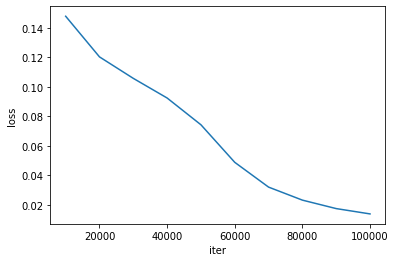

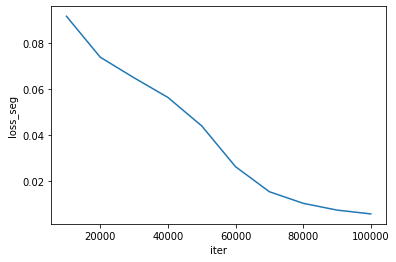

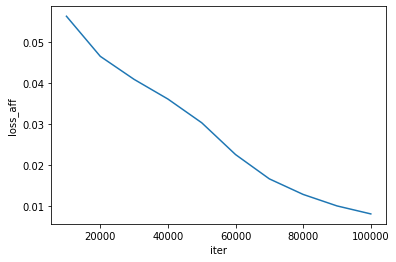

iter:100010, loss:0.0245, loss_seg:0.0110, loss_aff:0.0135
iter:100020, loss:0.0088, loss_seg:0.0034, loss_aff:0.0054
iter:100030, loss:0.0124, loss_seg:0.0048, loss_aff:0.0076
iter:100040, loss:0.0380, loss_seg:0.0265, loss_aff:0.0116
iter:100050, loss:0.0216, loss_seg:0.0087, loss_aff:0.0129
iter:100060, loss:0.0133, loss_seg:0.0052, loss_aff:0.0081
iter:100070, loss:0.0243, loss_seg:0.0109, loss_aff:0.0134
iter:100080, loss:0.0109, loss_seg:0.0048, loss_aff:0.0061
iter:100090, loss:0.0194, loss_seg:0.0096, loss_aff:0.0098
iter:100100, loss:0.1309, loss_seg:0.1115, loss_aff:0.0194
iter:100110, loss:0.0177, loss_seg:0.0070, loss_aff:0.0107
iter:100120, loss:0.0105, loss_seg:0.0035, loss_aff:0.0070
iter:100130, loss:0.0134, loss_seg:0.0057, loss_aff:0.0078
iter:100140, loss:0.0225, loss_seg:0.0087, loss_aff:0.0138
iter:100150, loss:0.0129, loss_seg:0.0047, loss_aff:0.0081
iter:100160, loss:0.0431, loss_seg:0.0173, loss_aff:0.0258
iter:100170, loss:0.0093, loss_seg:0.0039, loss_aff:0.00

iter:101380, loss:0.0140, loss_seg:0.0060, loss_aff:0.0080
iter:101390, loss:0.0042, loss_seg:0.0016, loss_aff:0.0027
iter:101400, loss:0.0052, loss_seg:0.0020, loss_aff:0.0032
iter:101410, loss:0.0071, loss_seg:0.0023, loss_aff:0.0047
iter:101420, loss:0.0078, loss_seg:0.0027, loss_aff:0.0051
iter:101430, loss:0.0134, loss_seg:0.0046, loss_aff:0.0088
iter:101440, loss:0.0062, loss_seg:0.0020, loss_aff:0.0042
iter:101450, loss:0.0091, loss_seg:0.0038, loss_aff:0.0054
iter:101460, loss:0.0062, loss_seg:0.0019, loss_aff:0.0043
iter:101470, loss:0.0056, loss_seg:0.0020, loss_aff:0.0036
iter:101480, loss:0.0047, loss_seg:0.0017, loss_aff:0.0030
iter:101490, loss:0.0076, loss_seg:0.0026, loss_aff:0.0050
iter:101500, loss:0.0062, loss_seg:0.0024, loss_aff:0.0039
iter:101510, loss:0.0081, loss_seg:0.0024, loss_aff:0.0057
iter:101520, loss:0.0050, loss_seg:0.0022, loss_aff:0.0028
iter:101530, loss:0.0050, loss_seg:0.0016, loss_aff:0.0033
iter:101540, loss:0.0076, loss_seg:0.0028, loss_aff:0.00

iter:102750, loss:0.0219, loss_seg:0.0097, loss_aff:0.0123
iter:102760, loss:0.0153, loss_seg:0.0064, loss_aff:0.0089
iter:102770, loss:0.0185, loss_seg:0.0103, loss_aff:0.0083
iter:102780, loss:0.0193, loss_seg:0.0070, loss_aff:0.0123
iter:102790, loss:0.0242, loss_seg:0.0118, loss_aff:0.0124
iter:102800, loss:0.0124, loss_seg:0.0056, loss_aff:0.0068
iter:102810, loss:0.0162, loss_seg:0.0055, loss_aff:0.0107
iter:102820, loss:0.0157, loss_seg:0.0049, loss_aff:0.0108
iter:102830, loss:0.0189, loss_seg:0.0083, loss_aff:0.0106
iter:102840, loss:0.0105, loss_seg:0.0037, loss_aff:0.0068
iter:102850, loss:0.0146, loss_seg:0.0054, loss_aff:0.0093
iter:102860, loss:0.0174, loss_seg:0.0055, loss_aff:0.0120
iter:102870, loss:0.0169, loss_seg:0.0066, loss_aff:0.0103
iter:102880, loss:0.0118, loss_seg:0.0039, loss_aff:0.0079
iter:102890, loss:0.0127, loss_seg:0.0046, loss_aff:0.0080
iter:102900, loss:0.0140, loss_seg:0.0056, loss_aff:0.0084
iter:102910, loss:0.0110, loss_seg:0.0042, loss_aff:0.00

iter:104100, loss:0.0076, loss_seg:0.0027, loss_aff:0.0049
iter:104110, loss:0.0040, loss_seg:0.0014, loss_aff:0.0026
iter:104120, loss:0.0085, loss_seg:0.0035, loss_aff:0.0050
iter:104130, loss:0.0071, loss_seg:0.0025, loss_aff:0.0045
iter:104140, loss:0.0057, loss_seg:0.0022, loss_aff:0.0035
iter:104150, loss:0.0045, loss_seg:0.0021, loss_aff:0.0024
iter:104160, loss:0.0045, loss_seg:0.0018, loss_aff:0.0027
iter:104170, loss:0.0158, loss_seg:0.0053, loss_aff:0.0105
iter:104180, loss:0.0112, loss_seg:0.0041, loss_aff:0.0072
iter:104190, loss:0.0111, loss_seg:0.0037, loss_aff:0.0074
iter:104200, loss:0.0071, loss_seg:0.0030, loss_aff:0.0041
iter:104210, loss:0.0046, loss_seg:0.0016, loss_aff:0.0029
iter:104220, loss:0.0081, loss_seg:0.0027, loss_aff:0.0054
iter:104230, loss:0.0090, loss_seg:0.0040, loss_aff:0.0050
iter:104240, loss:0.0105, loss_seg:0.0038, loss_aff:0.0066
iter:104250, loss:0.0091, loss_seg:0.0032, loss_aff:0.0058
iter:104260, loss:0.0100, loss_seg:0.0037, loss_aff:0.00

iter:105490, loss:0.0133, loss_seg:0.0060, loss_aff:0.0073
iter:105500, loss:0.0096, loss_seg:0.0039, loss_aff:0.0057
iter:105510, loss:0.0220, loss_seg:0.0088, loss_aff:0.0132
iter:105520, loss:0.0190, loss_seg:0.0086, loss_aff:0.0104
iter:105530, loss:0.0159, loss_seg:0.0066, loss_aff:0.0093
iter:105540, loss:0.0124, loss_seg:0.0049, loss_aff:0.0075
iter:105550, loss:0.0090, loss_seg:0.0026, loss_aff:0.0064
iter:105560, loss:0.0152, loss_seg:0.0051, loss_aff:0.0101
iter:105570, loss:0.0189, loss_seg:0.0100, loss_aff:0.0088
iter:105580, loss:0.0075, loss_seg:0.0029, loss_aff:0.0046
iter:105590, loss:0.0079, loss_seg:0.0024, loss_aff:0.0056
iter:105600, loss:0.0136, loss_seg:0.0057, loss_aff:0.0079
iter:105610, loss:0.0137, loss_seg:0.0070, loss_aff:0.0067
iter:105620, loss:0.0077, loss_seg:0.0025, loss_aff:0.0052
iter:105630, loss:0.0146, loss_seg:0.0054, loss_aff:0.0092
iter:105640, loss:0.0118, loss_seg:0.0038, loss_aff:0.0080
iter:105650, loss:0.0075, loss_seg:0.0024, loss_aff:0.00

iter:106860, loss:0.0115, loss_seg:0.0036, loss_aff:0.0079
iter:106870, loss:0.0090, loss_seg:0.0034, loss_aff:0.0056
iter:106880, loss:0.0122, loss_seg:0.0054, loss_aff:0.0068
iter:106890, loss:0.0114, loss_seg:0.0044, loss_aff:0.0071
iter:106900, loss:0.0102, loss_seg:0.0038, loss_aff:0.0064
iter:106910, loss:0.0118, loss_seg:0.0043, loss_aff:0.0075
iter:106920, loss:0.0167, loss_seg:0.0065, loss_aff:0.0102
iter:106930, loss:0.0235, loss_seg:0.0135, loss_aff:0.0100
iter:106940, loss:0.0159, loss_seg:0.0075, loss_aff:0.0084
iter:106950, loss:0.0138, loss_seg:0.0056, loss_aff:0.0082
iter:106960, loss:0.0288, loss_seg:0.0163, loss_aff:0.0124
iter:106970, loss:0.0227, loss_seg:0.0128, loss_aff:0.0099
iter:106980, loss:0.0211, loss_seg:0.0163, loss_aff:0.0049
iter:106990, loss:0.0144, loss_seg:0.0056, loss_aff:0.0089
iter:107000, loss:0.0189, loss_seg:0.0074, loss_aff:0.0116
iter:107010, loss:0.0169, loss_seg:0.0055, loss_aff:0.0113
iter:107020, loss:0.0059, loss_seg:0.0019, loss_aff:0.00

iter:108230, loss:0.0052, loss_seg:0.0023, loss_aff:0.0030
iter:108240, loss:0.0081, loss_seg:0.0031, loss_aff:0.0050
iter:108250, loss:0.0047, loss_seg:0.0017, loss_aff:0.0030
iter:108260, loss:0.0096, loss_seg:0.0038, loss_aff:0.0058
iter:108270, loss:0.0088, loss_seg:0.0037, loss_aff:0.0050
iter:108280, loss:0.0101, loss_seg:0.0035, loss_aff:0.0066
iter:108290, loss:0.0037, loss_seg:0.0019, loss_aff:0.0018
iter:108300, loss:0.0082, loss_seg:0.0030, loss_aff:0.0052
iter:108310, loss:0.0141, loss_seg:0.0046, loss_aff:0.0095
iter:108320, loss:0.0059, loss_seg:0.0020, loss_aff:0.0039
iter:108330, loss:0.0045, loss_seg:0.0013, loss_aff:0.0031
iter:108340, loss:0.0135, loss_seg:0.0055, loss_aff:0.0079
iter:108350, loss:0.0071, loss_seg:0.0036, loss_aff:0.0035
iter:108360, loss:0.0064, loss_seg:0.0023, loss_aff:0.0040
iter:108370, loss:0.0067, loss_seg:0.0030, loss_aff:0.0037
iter:108380, loss:0.0043, loss_seg:0.0015, loss_aff:0.0028
iter:108390, loss:0.0052, loss_seg:0.0017, loss_aff:0.00

iter:109600, loss:0.0099, loss_seg:0.0039, loss_aff:0.0060
iter:109610, loss:0.0125, loss_seg:0.0048, loss_aff:0.0077
iter:109620, loss:0.0108, loss_seg:0.0041, loss_aff:0.0067
iter:109630, loss:0.0078, loss_seg:0.0024, loss_aff:0.0054
iter:109640, loss:0.0082, loss_seg:0.0031, loss_aff:0.0051
iter:109650, loss:0.0097, loss_seg:0.0039, loss_aff:0.0058
iter:109660, loss:0.0073, loss_seg:0.0024, loss_aff:0.0050
iter:109670, loss:0.0107, loss_seg:0.0031, loss_aff:0.0077
iter:109680, loss:0.0051, loss_seg:0.0017, loss_aff:0.0035
iter:109690, loss:0.0106, loss_seg:0.0037, loss_aff:0.0069
iter:109700, loss:0.0089, loss_seg:0.0034, loss_aff:0.0055
iter:109710, loss:0.0094, loss_seg:0.0038, loss_aff:0.0057
iter:109720, loss:0.0152, loss_seg:0.0053, loss_aff:0.0098
iter:109730, loss:0.0106, loss_seg:0.0044, loss_aff:0.0063
iter:109740, loss:0.0076, loss_seg:0.0026, loss_aff:0.0051
iter:109750, loss:0.0116, loss_seg:0.0032, loss_aff:0.0084
iter:109760, loss:0.0119, loss_seg:0.0044, loss_aff:0.00

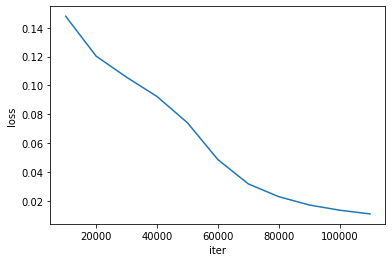

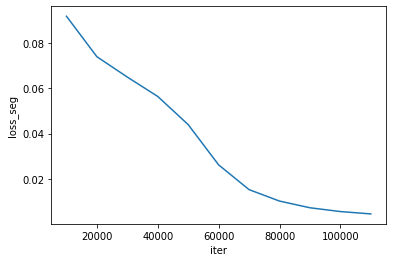

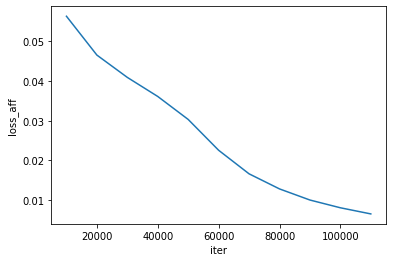

iter:110010, loss:0.0176, loss_seg:0.0075, loss_aff:0.0100
iter:110020, loss:0.0064, loss_seg:0.0023, loss_aff:0.0041
iter:110030, loss:0.0127, loss_seg:0.0042, loss_aff:0.0085
iter:110040, loss:0.0049, loss_seg:0.0016, loss_aff:0.0033
iter:110050, loss:0.0128, loss_seg:0.0053, loss_aff:0.0075
iter:110060, loss:0.0158, loss_seg:0.0059, loss_aff:0.0099
iter:110070, loss:0.0063, loss_seg:0.0021, loss_aff:0.0042
iter:110080, loss:0.0088, loss_seg:0.0030, loss_aff:0.0058
iter:110090, loss:0.0238, loss_seg:0.0084, loss_aff:0.0155
iter:110100, loss:0.0087, loss_seg:0.0029, loss_aff:0.0059
iter:110110, loss:0.0088, loss_seg:0.0030, loss_aff:0.0058
iter:110120, loss:0.0105, loss_seg:0.0034, loss_aff:0.0072
iter:110130, loss:0.0075, loss_seg:0.0028, loss_aff:0.0047
iter:110140, loss:0.0087, loss_seg:0.0032, loss_aff:0.0055
iter:110150, loss:0.0071, loss_seg:0.0034, loss_aff:0.0037
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_sp

iter:111360, loss:0.0283, loss_seg:0.0085, loss_aff:0.0198
iter:111370, loss:0.0139, loss_seg:0.0058, loss_aff:0.0081
iter:111380, loss:0.0093, loss_seg:0.0034, loss_aff:0.0059
iter:111390, loss:0.0153, loss_seg:0.0049, loss_aff:0.0104
iter:111400, loss:0.0185, loss_seg:0.0067, loss_aff:0.0119
iter:111410, loss:0.0105, loss_seg:0.0034, loss_aff:0.0072
iter:111420, loss:0.0181, loss_seg:0.0118, loss_aff:0.0063
iter:111430, loss:0.0081, loss_seg:0.0029, loss_aff:0.0052
iter:111440, loss:0.0112, loss_seg:0.0036, loss_aff:0.0076
iter:111450, loss:0.0082, loss_seg:0.0035, loss_aff:0.0046
iter:111460, loss:0.0078, loss_seg:0.0028, loss_aff:0.0051
iter:111470, loss:0.0074, loss_seg:0.0034, loss_aff:0.0040
iter:111480, loss:0.0100, loss_seg:0.0041, loss_aff:0.0059
iter:111490, loss:0.0092, loss_seg:0.0032, loss_aff:0.0060
iter:111500, loss:0.0097, loss_seg:0.0035, loss_aff:0.0062
iter:111510, loss:0.0078, loss_seg:0.0028, loss_aff:0.0050
iter:111520, loss:0.0062, loss_seg:0.0021, loss_aff:0.00

iter:112710, loss:0.0044, loss_seg:0.0016, loss_aff:0.0028
iter:112720, loss:0.0066, loss_seg:0.0025, loss_aff:0.0041
iter:112730, loss:0.0042, loss_seg:0.0015, loss_aff:0.0026
iter:112740, loss:0.0083, loss_seg:0.0030, loss_aff:0.0053
iter:112750, loss:0.0055, loss_seg:0.0020, loss_aff:0.0035
iter:112760, loss:0.0087, loss_seg:0.0024, loss_aff:0.0063
iter:112770, loss:0.0041, loss_seg:0.0013, loss_aff:0.0028
iter:112780, loss:0.0063, loss_seg:0.0029, loss_aff:0.0034
iter:112790, loss:0.0085, loss_seg:0.0037, loss_aff:0.0048
iter:112800, loss:0.0049, loss_seg:0.0022, loss_aff:0.0027
iter:112810, loss:0.0059, loss_seg:0.0017, loss_aff:0.0041
iter:112820, loss:0.0065, loss_seg:0.0023, loss_aff:0.0043
iter:112830, loss:0.0056, loss_seg:0.0027, loss_aff:0.0029
iter:112840, loss:0.0075, loss_seg:0.0029, loss_aff:0.0046
iter:112850, loss:0.0084, loss_seg:0.0031, loss_aff:0.0053
iter:112860, loss:0.0073, loss_seg:0.0031, loss_aff:0.0042
iter:112870, loss:0.0075, loss_seg:0.0027, loss_aff:0.00

iter:114100, loss:0.0095, loss_seg:0.0036, loss_aff:0.0060
iter:114110, loss:0.0048, loss_seg:0.0013, loss_aff:0.0035
iter:114120, loss:0.0112, loss_seg:0.0041, loss_aff:0.0071
iter:114130, loss:0.0098, loss_seg:0.0040, loss_aff:0.0058
iter:114140, loss:0.0091, loss_seg:0.0035, loss_aff:0.0056
iter:114150, loss:0.0054, loss_seg:0.0018, loss_aff:0.0036
iter:114160, loss:0.0068, loss_seg:0.0024, loss_aff:0.0045
iter:114170, loss:0.0137, loss_seg:0.0051, loss_aff:0.0086
iter:114180, loss:0.0065, loss_seg:0.0031, loss_aff:0.0034
iter:114190, loss:0.0069, loss_seg:0.0024, loss_aff:0.0045
iter:114200, loss:0.0209, loss_seg:0.0076, loss_aff:0.0133
iter:114210, loss:0.0085, loss_seg:0.0033, loss_aff:0.0053
iter:114220, loss:0.0073, loss_seg:0.0023, loss_aff:0.0050
iter:114230, loss:0.0063, loss_seg:0.0030, loss_aff:0.0033
iter:114240, loss:0.0083, loss_seg:0.0036, loss_aff:0.0047
iter:114250, loss:0.0155, loss_seg:0.0058, loss_aff:0.0098
iter:114260, loss:0.0086, loss_seg:0.0033, loss_aff:0.00

iter:115490, loss:0.0186, loss_seg:0.0117, loss_aff:0.0069
iter:115500, loss:0.0045, loss_seg:0.0013, loss_aff:0.0031
iter:115510, loss:0.0061, loss_seg:0.0022, loss_aff:0.0040
iter:115520, loss:0.0050, loss_seg:0.0016, loss_aff:0.0034
iter:115530, loss:0.0073, loss_seg:0.0021, loss_aff:0.0053
iter:115540, loss:0.0049, loss_seg:0.0020, loss_aff:0.0029
iter:115550, loss:0.0094, loss_seg:0.0041, loss_aff:0.0053
iter:115560, loss:0.0080, loss_seg:0.0037, loss_aff:0.0043
iter:115570, loss:0.0072, loss_seg:0.0027, loss_aff:0.0045
iter:115580, loss:0.0061, loss_seg:0.0031, loss_aff:0.0030
iter:115590, loss:0.0036, loss_seg:0.0016, loss_aff:0.0020
iter:115600, loss:0.0170, loss_seg:0.0079, loss_aff:0.0091
iter:115610, loss:0.0176, loss_seg:0.0059, loss_aff:0.0117
iter:115620, loss:0.0100, loss_seg:0.0043, loss_aff:0.0056
iter:115630, loss:0.0108, loss_seg:0.0046, loss_aff:0.0062
iter:115640, loss:0.0060, loss_seg:0.0019, loss_aff:0.0042
iter:115650, loss:0.0130, loss_seg:0.0055, loss_aff:0.00

iter:116840, loss:0.0058, loss_seg:0.0016, loss_aff:0.0042
iter:116850, loss:0.0049, loss_seg:0.0019, loss_aff:0.0030
iter:116860, loss:0.0042, loss_seg:0.0011, loss_aff:0.0031
iter:116870, loss:0.0080, loss_seg:0.0034, loss_aff:0.0046
iter:116880, loss:0.0050, loss_seg:0.0015, loss_aff:0.0035
iter:116890, loss:0.0098, loss_seg:0.0048, loss_aff:0.0050
iter:116900, loss:0.0058, loss_seg:0.0024, loss_aff:0.0035
iter:116910, loss:0.0069, loss_seg:0.0028, loss_aff:0.0041
iter:116920, loss:0.0070, loss_seg:0.0024, loss_aff:0.0046
iter:116930, loss:0.0083, loss_seg:0.0036, loss_aff:0.0047
iter:116940, loss:0.0188, loss_seg:0.0074, loss_aff:0.0114
iter:116950, loss:0.0078, loss_seg:0.0023, loss_aff:0.0054
iter:116960, loss:0.0058, loss_seg:0.0018, loss_aff:0.0040
iter:116970, loss:0.0070, loss_seg:0.0025, loss_aff:0.0045
iter:116980, loss:0.0075, loss_seg:0.0027, loss_aff:0.0049
iter:116990, loss:0.0058, loss_seg:0.0025, loss_aff:0.0032
iter:117000, loss:0.0085, loss_seg:0.0028, loss_aff:0.00

iter:118210, loss:0.0103, loss_seg:0.0037, loss_aff:0.0066
iter:118220, loss:0.0041, loss_seg:0.0016, loss_aff:0.0024
iter:118230, loss:0.0103, loss_seg:0.0031, loss_aff:0.0072
iter:118240, loss:0.0072, loss_seg:0.0031, loss_aff:0.0041
iter:118250, loss:0.0085, loss_seg:0.0038, loss_aff:0.0047
iter:118260, loss:0.0053, loss_seg:0.0026, loss_aff:0.0027
iter:118270, loss:0.0055, loss_seg:0.0022, loss_aff:0.0033
iter:118280, loss:0.0082, loss_seg:0.0033, loss_aff:0.0049
iter:118290, loss:0.0078, loss_seg:0.0025, loss_aff:0.0053
iter:118300, loss:0.0071, loss_seg:0.0034, loss_aff:0.0037
iter:118310, loss:0.0141, loss_seg:0.0076, loss_aff:0.0064
iter:118320, loss:0.0026, loss_seg:0.0009, loss_aff:0.0017
iter:118330, loss:0.0053, loss_seg:0.0022, loss_aff:0.0031
iter:118340, loss:0.0150, loss_seg:0.0052, loss_aff:0.0098
iter:118350, loss:0.0058, loss_seg:0.0020, loss_aff:0.0038
iter:118360, loss:0.0024, loss_seg:0.0010, loss_aff:0.0014
iter:118370, loss:0.0076, loss_seg:0.0024, loss_aff:0.00

iter:119580, loss:0.0064, loss_seg:0.0016, loss_aff:0.0048
iter:119590, loss:0.0067, loss_seg:0.0021, loss_aff:0.0046
iter:119600, loss:0.0056, loss_seg:0.0026, loss_aff:0.0031
iter:119610, loss:0.0040, loss_seg:0.0016, loss_aff:0.0024
iter:119620, loss:0.0063, loss_seg:0.0024, loss_aff:0.0039
iter:119630, loss:0.0071, loss_seg:0.0030, loss_aff:0.0041
iter:119640, loss:0.0041, loss_seg:0.0010, loss_aff:0.0032
iter:119650, loss:0.0067, loss_seg:0.0029, loss_aff:0.0039
iter:119660, loss:0.0047, loss_seg:0.0018, loss_aff:0.0029
iter:119670, loss:0.0091, loss_seg:0.0037, loss_aff:0.0054
iter:119680, loss:0.0110, loss_seg:0.0032, loss_aff:0.0077
iter:119690, loss:0.0097, loss_seg:0.0039, loss_aff:0.0057
iter:119700, loss:0.0063, loss_seg:0.0023, loss_aff:0.0040
iter:119710, loss:0.0045, loss_seg:0.0015, loss_aff:0.0030
iter:119720, loss:0.0104, loss_seg:0.0040, loss_aff:0.0064
iter:119730, loss:0.0100, loss_seg:0.0037, loss_aff:0.0063
iter:119740, loss:0.0130, loss_seg:0.0049, loss_aff:0.00

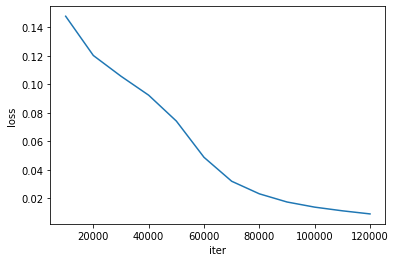

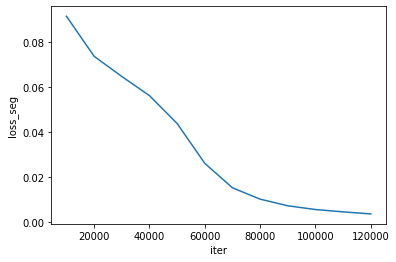

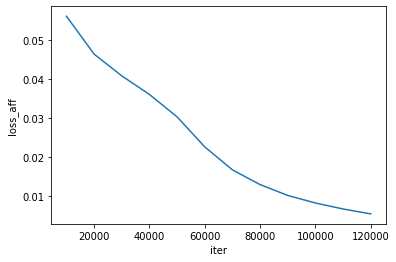

iter:120010, loss:0.0077, loss_seg:0.0028, loss_aff:0.0048
iter:120020, loss:0.0111, loss_seg:0.0032, loss_aff:0.0079
iter:120030, loss:0.0046, loss_seg:0.0021, loss_aff:0.0025
iter:120040, loss:0.0069, loss_seg:0.0025, loss_aff:0.0044
iter:120050, loss:0.0066, loss_seg:0.0018, loss_aff:0.0048
iter:120060, loss:0.0068, loss_seg:0.0030, loss_aff:0.0039
iter:120070, loss:0.0150, loss_seg:0.0061, loss_aff:0.0090
iter:120080, loss:0.0098, loss_seg:0.0042, loss_aff:0.0056
iter:120090, loss:0.0104, loss_seg:0.0033, loss_aff:0.0071
iter:120100, loss:0.0114, loss_seg:0.0031, loss_aff:0.0083
iter:120110, loss:0.0079, loss_seg:0.0021, loss_aff:0.0058
iter:120120, loss:0.0075, loss_seg:0.0025, loss_aff:0.0049
iter:120130, loss:0.0063, loss_seg:0.0016, loss_aff:0.0047
iter:120140, loss:0.0087, loss_seg:0.0033, loss_aff:0.0053
iter:120150, loss:0.0068, loss_seg:0.0027, loss_aff:0.0041
iter:120160, loss:0.0036, loss_seg:0.0014, loss_aff:0.0023
iter:120170, loss:0.0060, loss_seg:0.0022, loss_aff:0.00

iter:121400, loss:0.0130, loss_seg:0.0044, loss_aff:0.0086
iter:121410, loss:0.0171, loss_seg:0.0059, loss_aff:0.0112
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:121420, loss:0.0066, loss_seg:0.0023, loss_aff:0.0043
iter:121430, loss:0.0079, loss_seg:0.0035, loss_aff:0.0044
iter:121440, loss:0.0043, loss_seg:0.0015, loss_aff:0.0028
iter:121450, loss:0.0119, loss_seg:0.0043, loss_aff:0.0076
iter:121460, loss:0.0060, loss_seg:0.0031, loss_aff:0.0028
iter:121470, loss:0.0031, loss_seg:0.0015, loss_aff:0.0015
iter:121480, loss:0.0066, loss_seg:0.0028, loss_aff:0.0038
iter:121490, loss:0.0105, loss_seg:0.0046, loss_aff:0.0060
iter:121500, loss:0.0063, loss_seg:0.0025, loss_aff:0.0038
iter:121510, loss:0.0171, loss_seg:0.0070, loss_aff:0.0101
iter:121520, loss:0.0055, loss_seg:0.0019, loss_aff:0.0036
iter:121530, loss:0.0052, loss_seg:0.0020, loss_aff:0.0032
iter:121540, loss:0.0125, loss_seg:0

iter:122700, loss:0.0095, loss_seg:0.0033, loss_aff:0.0063
iter:122710, loss:0.0153, loss_seg:0.0065, loss_aff:0.0088
iter:122720, loss:0.0065, loss_seg:0.0028, loss_aff:0.0037
iter:122730, loss:0.0141, loss_seg:0.0052, loss_aff:0.0088
iter:122740, loss:0.0061, loss_seg:0.0029, loss_aff:0.0033
iter:122750, loss:0.0080, loss_seg:0.0029, loss_aff:0.0051
iter:122760, loss:0.0063, loss_seg:0.0024, loss_aff:0.0039
iter:122770, loss:0.0131, loss_seg:0.0044, loss_aff:0.0087
iter:122780, loss:0.0085, loss_seg:0.0034, loss_aff:0.0051
iter:122790, loss:0.0119, loss_seg:0.0066, loss_aff:0.0053
iter:122800, loss:0.0105, loss_seg:0.0041, loss_aff:0.0065
iter:122810, loss:0.0054, loss_seg:0.0020, loss_aff:0.0034
iter:122820, loss:0.0079, loss_seg:0.0025, loss_aff:0.0054
iter:122830, loss:0.0105, loss_seg:0.0034, loss_aff:0.0071
iter:122840, loss:0.0034, loss_seg:0.0011, loss_aff:0.0023
iter:122850, loss:0.0066, loss_seg:0.0030, loss_aff:0.0035
iter:122860, loss:0.0083, loss_seg:0.0033, loss_aff:0.00

iter:124070, loss:0.0087, loss_seg:0.0043, loss_aff:0.0044
iter:124080, loss:0.0049, loss_seg:0.0021, loss_aff:0.0028
iter:124090, loss:0.0080, loss_seg:0.0034, loss_aff:0.0047
iter:124100, loss:0.0062, loss_seg:0.0023, loss_aff:0.0039
iter:124110, loss:0.0035, loss_seg:0.0013, loss_aff:0.0022
iter:124120, loss:0.0086, loss_seg:0.0035, loss_aff:0.0051
iter:124130, loss:0.0131, loss_seg:0.0058, loss_aff:0.0073
iter:124140, loss:0.0067, loss_seg:0.0032, loss_aff:0.0035
iter:124150, loss:0.0068, loss_seg:0.0026, loss_aff:0.0042
iter:124160, loss:0.0066, loss_seg:0.0036, loss_aff:0.0031
iter:124170, loss:0.0103, loss_seg:0.0027, loss_aff:0.0075
iter:124180, loss:0.0082, loss_seg:0.0034, loss_aff:0.0049
iter:124190, loss:0.0052, loss_seg:0.0019, loss_aff:0.0033
iter:124200, loss:0.0064, loss_seg:0.0026, loss_aff:0.0038
iter:124210, loss:0.0050, loss_seg:0.0019, loss_aff:0.0031
iter:124220, loss:0.0060, loss_seg:0.0029, loss_aff:0.0031
iter:124230, loss:0.0051, loss_seg:0.0022, loss_aff:0.00

Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_19/0703/00006.png'
iter:125440, loss:0.0047, loss_seg:0.0019, loss_aff:0.0028
iter:125450, loss:0.0050, loss_seg:0.0022, loss_aff:0.0028
iter:125460, loss:0.0062, loss_seg:0.0024, loss_aff:0.0038
iter:125470, loss:0.0070, loss_seg:0.0023, loss_aff:0.0046
iter:125480, loss:0.0067, loss_seg:0.0022, loss_aff:0.0045
iter:125490, loss:0.0064, loss_seg:0.0028, loss_aff:0.0037
iter:125500, loss:0.0191, loss_seg:0.0144, loss_aff:0.0046
iter:125510, loss:0.0050, loss_seg:0.0020, loss_aff:0.0030
iter:125520, loss:0.0047, loss_seg:0.0020, loss_aff:0.0027
iter:125530, loss:0.0042, loss_seg:0.0018, loss_aff:0.0024
iter:125540, loss:0.0058, loss_seg:0.0026, loss_aff:0.0032
iter:125550, loss:0.0079, loss_seg:0.0030, loss_aff:0.0049
iter:125560, loss:0.0057, loss_seg:0.0019, loss_aff:0.0038
iter:125570, loss:0.0054, loss_seg:0.0023, loss_aff:0.0032
iter:125580, loss:0.0099, loss_seg:0

iter:126810, loss:0.0024, loss_seg:0.0008, loss_aff:0.0016
iter:126820, loss:0.0042, loss_seg:0.0016, loss_aff:0.0027
iter:126830, loss:0.0076, loss_seg:0.0027, loss_aff:0.0048
iter:126840, loss:0.0056, loss_seg:0.0029, loss_aff:0.0027
iter:126850, loss:0.0029, loss_seg:0.0010, loss_aff:0.0018
iter:126860, loss:0.0043, loss_seg:0.0016, loss_aff:0.0027
iter:126870, loss:0.0065, loss_seg:0.0024, loss_aff:0.0041
iter:126880, loss:0.0051, loss_seg:0.0024, loss_aff:0.0027
iter:126890, loss:0.0032, loss_seg:0.0011, loss_aff:0.0021
iter:126900, loss:0.0044, loss_seg:0.0017, loss_aff:0.0027
iter:126910, loss:0.0046, loss_seg:0.0020, loss_aff:0.0026
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_7/1031/00006.png'
iter:126920, loss:0.0078, loss_seg:0.0029, loss_aff:0.0049
iter:126930, loss:0.0025, loss_seg:0.0009, loss_aff:0.0016
iter:126940, loss:0.0029, loss_seg:0.0009, loss_aff:0.0020
iter:126950, loss:0.0059, loss_seg:0.

iter:128180, loss:0.0125, loss_seg:0.0059, loss_aff:0.0066
iter:128190, loss:0.0122, loss_seg:0.0050, loss_aff:0.0072
iter:128200, loss:0.0072, loss_seg:0.0028, loss_aff:0.0043
iter:128210, loss:0.0072, loss_seg:0.0029, loss_aff:0.0044
iter:128220, loss:0.0135, loss_seg:0.0046, loss_aff:0.0089
iter:128230, loss:0.0139, loss_seg:0.0053, loss_aff:0.0086
iter:128240, loss:0.0233, loss_seg:0.0094, loss_aff:0.0139
iter:128250, loss:0.0092, loss_seg:0.0028, loss_aff:0.0064
iter:128260, loss:0.0139, loss_seg:0.0072, loss_aff:0.0066
iter:128270, loss:0.0101, loss_seg:0.0039, loss_aff:0.0063
iter:128280, loss:0.0154, loss_seg:0.0067, loss_aff:0.0087
iter:128290, loss:0.0118, loss_seg:0.0034, loss_aff:0.0084
iter:128300, loss:0.0160, loss_seg:0.0097, loss_aff:0.0063
iter:128310, loss:0.0231, loss_seg:0.0093, loss_aff:0.0138
iter:128320, loss:0.0061, loss_seg:0.0019, loss_aff:0.0042
iter:128330, loss:0.0088, loss_seg:0.0035, loss_aff:0.0052
iter:128340, loss:0.0200, loss_seg:0.0083, loss_aff:0.01

iter:129530, loss:0.0055, loss_seg:0.0027, loss_aff:0.0029
iter:129540, loss:0.0063, loss_seg:0.0022, loss_aff:0.0041
iter:129550, loss:0.0056, loss_seg:0.0022, loss_aff:0.0034
iter:129560, loss:0.0056, loss_seg:0.0021, loss_aff:0.0035
iter:129570, loss:0.0063, loss_seg:0.0022, loss_aff:0.0041
iter:129580, loss:0.0043, loss_seg:0.0017, loss_aff:0.0026
iter:129590, loss:0.0080, loss_seg:0.0035, loss_aff:0.0045
iter:129600, loss:0.0042, loss_seg:0.0017, loss_aff:0.0025
iter:129610, loss:0.0057, loss_seg:0.0023, loss_aff:0.0034
iter:129620, loss:0.0052, loss_seg:0.0023, loss_aff:0.0029
iter:129630, loss:0.0028, loss_seg:0.0014, loss_aff:0.0015
iter:129640, loss:0.0066, loss_seg:0.0017, loss_aff:0.0048
iter:129650, loss:0.0051, loss_seg:0.0021, loss_aff:0.0030
iter:129660, loss:0.0061, loss_seg:0.0025, loss_aff:0.0036
iter:129670, loss:0.0051, loss_seg:0.0016, loss_aff:0.0034
iter:129680, loss:0.0109, loss_seg:0.0036, loss_aff:0.0073
iter:129690, loss:0.0068, loss_seg:0.0027, loss_aff:0.00

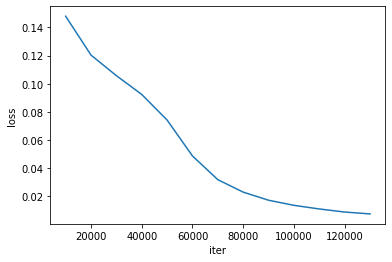

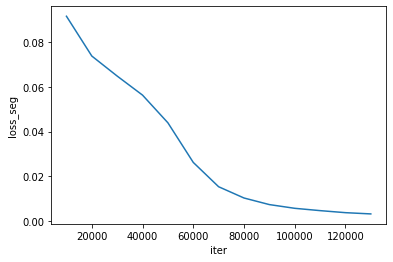

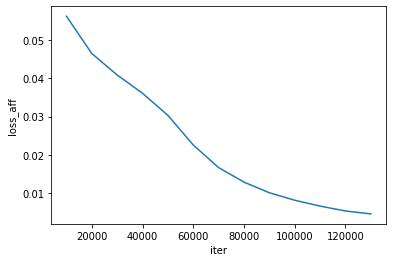

iter:130010, loss:0.0048, loss_seg:0.0021, loss_aff:0.0027
iter:130020, loss:0.0072, loss_seg:0.0028, loss_aff:0.0044
iter:130030, loss:0.0103, loss_seg:0.0059, loss_aff:0.0043
iter:130040, loss:0.0047, loss_seg:0.0017, loss_aff:0.0030
iter:130050, loss:0.0034, loss_seg:0.0014, loss_aff:0.0020
iter:130060, loss:0.0023, loss_seg:0.0009, loss_aff:0.0013
iter:130070, loss:0.0055, loss_seg:0.0022, loss_aff:0.0033
iter:130080, loss:0.0037, loss_seg:0.0013, loss_aff:0.0024
iter:130090, loss:0.0034, loss_seg:0.0013, loss_aff:0.0022
iter:130100, loss:0.0065, loss_seg:0.0024, loss_aff:0.0041
iter:130110, loss:0.0045, loss_seg:0.0017, loss_aff:0.0027
iter:130120, loss:0.0046, loss_seg:0.0025, loss_aff:0.0021
iter:130130, loss:0.0039, loss_seg:0.0017, loss_aff:0.0022
iter:130140, loss:0.0038, loss_seg:0.0012, loss_aff:0.0026
iter:130150, loss:0.0067, loss_seg:0.0020, loss_aff:0.0047
iter:130160, loss:0.0052, loss_seg:0.0021, loss_aff:0.0030
iter:130170, loss:0.0074, loss_seg:0.0021, loss_aff:0.00

iter:131360, loss:0.0052, loss_seg:0.0019, loss_aff:0.0033
iter:131370, loss:0.0043, loss_seg:0.0017, loss_aff:0.0025
iter:131380, loss:0.0058, loss_seg:0.0017, loss_aff:0.0042
iter:131390, loss:0.0054, loss_seg:0.0020, loss_aff:0.0034
iter:131400, loss:0.0100, loss_seg:0.0035, loss_aff:0.0065
iter:131410, loss:0.0109, loss_seg:0.0047, loss_aff:0.0062
iter:131420, loss:0.0090, loss_seg:0.0032, loss_aff:0.0058
iter:131430, loss:0.0053, loss_seg:0.0021, loss_aff:0.0033
iter:131440, loss:0.0055, loss_seg:0.0020, loss_aff:0.0034
iter:131450, loss:0.0532, loss_seg:0.0441, loss_aff:0.0090
iter:131460, loss:0.0220, loss_seg:0.0084, loss_aff:0.0135
iter:131470, loss:0.0646, loss_seg:0.0460, loss_aff:0.0186
iter:131480, loss:0.0148, loss_seg:0.0060, loss_aff:0.0088
iter:131490, loss:0.0653, loss_seg:0.0490, loss_aff:0.0164
iter:131500, loss:0.0116, loss_seg:0.0049, loss_aff:0.0067
iter:131510, loss:0.0143, loss_seg:0.0062, loss_aff:0.0081
iter:131520, loss:0.0127, loss_seg:0.0061, loss_aff:0.00

iter:132750, loss:0.0082, loss_seg:0.0030, loss_aff:0.0052
iter:132760, loss:0.0044, loss_seg:0.0019, loss_aff:0.0025
iter:132770, loss:0.0045, loss_seg:0.0019, loss_aff:0.0026
iter:132780, loss:0.0029, loss_seg:0.0013, loss_aff:0.0016
iter:132790, loss:0.0033, loss_seg:0.0012, loss_aff:0.0021
iter:132800, loss:0.0046, loss_seg:0.0019, loss_aff:0.0027
iter:132810, loss:0.0037, loss_seg:0.0015, loss_aff:0.0021
iter:132820, loss:0.0032, loss_seg:0.0015, loss_aff:0.0017
iter:132830, loss:0.0050, loss_seg:0.0021, loss_aff:0.0029
iter:132840, loss:0.0035, loss_seg:0.0017, loss_aff:0.0018
iter:132850, loss:0.0015, loss_seg:0.0007, loss_aff:0.0008
iter:132860, loss:0.0027, loss_seg:0.0010, loss_aff:0.0018
iter:132870, loss:0.0031, loss_seg:0.0011, loss_aff:0.0020
iter:132880, loss:0.0040, loss_seg:0.0019, loss_aff:0.0022
iter:132890, loss:0.0036, loss_seg:0.0013, loss_aff:0.0023
iter:132900, loss:0.0058, loss_seg:0.0025, loss_aff:0.0033
iter:132910, loss:0.0030, loss_seg:0.0015, loss_aff:0.00

iter:134120, loss:0.0045, loss_seg:0.0016, loss_aff:0.0028
iter:134130, loss:0.0049, loss_seg:0.0021, loss_aff:0.0028
iter:134140, loss:0.0029, loss_seg:0.0015, loss_aff:0.0014
iter:134150, loss:0.0034, loss_seg:0.0016, loss_aff:0.0018
iter:134160, loss:0.0047, loss_seg:0.0021, loss_aff:0.0026
iter:134170, loss:0.0072, loss_seg:0.0029, loss_aff:0.0043
iter:134180, loss:0.0023, loss_seg:0.0006, loss_aff:0.0017
iter:134190, loss:0.0036, loss_seg:0.0016, loss_aff:0.0020
iter:134200, loss:0.0042, loss_seg:0.0016, loss_aff:0.0027
iter:134210, loss:0.0035, loss_seg:0.0019, loss_aff:0.0016
iter:134220, loss:0.0052, loss_seg:0.0017, loss_aff:0.0035
iter:134230, loss:0.0033, loss_seg:0.0015, loss_aff:0.0019
iter:134240, loss:0.0053, loss_seg:0.0023, loss_aff:0.0030
iter:134250, loss:0.0066, loss_seg:0.0039, loss_aff:0.0028
iter:134260, loss:0.0034, loss_seg:0.0015, loss_aff:0.0020
iter:134270, loss:0.0029, loss_seg:0.0013, loss_aff:0.0016
iter:134280, loss:0.0031, loss_seg:0.0013, loss_aff:0.00

iter:135490, loss:0.0057, loss_seg:0.0022, loss_aff:0.0035
iter:135500, loss:0.0104, loss_seg:0.0035, loss_aff:0.0069
iter:135510, loss:0.0078, loss_seg:0.0026, loss_aff:0.0052
iter:135520, loss:0.0065, loss_seg:0.0021, loss_aff:0.0044
iter:135530, loss:0.0072, loss_seg:0.0022, loss_aff:0.0050
iter:135540, loss:0.0047, loss_seg:0.0015, loss_aff:0.0032
iter:135550, loss:0.0269, loss_seg:0.0158, loss_aff:0.0111
Encounter error: [Errno 2] No such file or directory: '/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_25/0872/00006.png'
iter:135560, loss:0.0921, loss_seg:0.0585, loss_aff:0.0336
iter:135570, loss:0.0081, loss_seg:0.0036, loss_aff:0.0044
iter:135580, loss:0.0083, loss_seg:0.0036, loss_aff:0.0047
iter:135590, loss:0.0077, loss_seg:0.0025, loss_aff:0.0052
iter:135600, loss:0.0086, loss_seg:0.0036, loss_aff:0.0050
iter:135610, loss:0.0085, loss_seg:0.0029, loss_aff:0.0056
iter:135620, loss:0.0050, loss_seg:0.0021, loss_aff:0.0029
iter:135630, loss:0.0058, loss_seg:0

iter:136860, loss:0.0042, loss_seg:0.0016, loss_aff:0.0026
iter:136870, loss:0.0044, loss_seg:0.0020, loss_aff:0.0024
iter:136880, loss:0.0032, loss_seg:0.0013, loss_aff:0.0019
iter:136890, loss:0.0060, loss_seg:0.0019, loss_aff:0.0040
iter:136900, loss:0.0057, loss_seg:0.0029, loss_aff:0.0028
iter:136910, loss:0.0108, loss_seg:0.0061, loss_aff:0.0047
iter:136920, loss:0.0034, loss_seg:0.0014, loss_aff:0.0019
iter:136930, loss:0.0036, loss_seg:0.0013, loss_aff:0.0023
iter:136940, loss:0.0044, loss_seg:0.0016, loss_aff:0.0028
iter:136950, loss:0.0065, loss_seg:0.0021, loss_aff:0.0044
iter:136960, loss:0.0069, loss_seg:0.0017, loss_aff:0.0053
iter:136970, loss:0.0062, loss_seg:0.0024, loss_aff:0.0038
iter:136980, loss:0.0044, loss_seg:0.0018, loss_aff:0.0026
iter:136990, loss:0.0107, loss_seg:0.0035, loss_aff:0.0073
iter:137000, loss:0.0036, loss_seg:0.0014, loss_aff:0.0021
iter:137010, loss:0.0044, loss_seg:0.0020, loss_aff:0.0024
iter:137020, loss:0.0037, loss_seg:0.0014, loss_aff:0.00

iter:138210, loss:0.0115, loss_seg:0.0060, loss_aff:0.0055
iter:138220, loss:0.0042, loss_seg:0.0013, loss_aff:0.0029
iter:138230, loss:0.0040, loss_seg:0.0018, loss_aff:0.0022
iter:138240, loss:0.0082, loss_seg:0.0030, loss_aff:0.0051
iter:138250, loss:0.0113, loss_seg:0.0044, loss_aff:0.0069
iter:138260, loss:0.0057, loss_seg:0.0033, loss_aff:0.0024
iter:138270, loss:0.0033, loss_seg:0.0012, loss_aff:0.0022
iter:138280, loss:0.0056, loss_seg:0.0024, loss_aff:0.0033
iter:138290, loss:0.0070, loss_seg:0.0030, loss_aff:0.0040
iter:138300, loss:0.0018, loss_seg:0.0007, loss_aff:0.0012
iter:138310, loss:0.0089, loss_seg:0.0037, loss_aff:0.0052
iter:138320, loss:0.0039, loss_seg:0.0020, loss_aff:0.0019
iter:138330, loss:0.0072, loss_seg:0.0026, loss_aff:0.0046
iter:138340, loss:0.0058, loss_seg:0.0020, loss_aff:0.0038
iter:138350, loss:0.0109, loss_seg:0.0037, loss_aff:0.0073
iter:138360, loss:0.0047, loss_seg:0.0021, loss_aff:0.0026
iter:138370, loss:0.0082, loss_seg:0.0029, loss_aff:0.00

iter:139580, loss:0.0056, loss_seg:0.0024, loss_aff:0.0032
iter:139590, loss:0.0018, loss_seg:0.0009, loss_aff:0.0009
iter:139600, loss:0.0039, loss_seg:0.0018, loss_aff:0.0022
iter:139610, loss:0.0129, loss_seg:0.0093, loss_aff:0.0036
iter:139620, loss:0.0032, loss_seg:0.0011, loss_aff:0.0022
iter:139630, loss:0.0026, loss_seg:0.0012, loss_aff:0.0014
iter:139640, loss:0.0017, loss_seg:0.0007, loss_aff:0.0010
iter:139650, loss:0.0072, loss_seg:0.0036, loss_aff:0.0036
iter:139660, loss:0.0119, loss_seg:0.0049, loss_aff:0.0070
iter:139670, loss:0.0044, loss_seg:0.0017, loss_aff:0.0027
iter:139680, loss:0.0036, loss_seg:0.0018, loss_aff:0.0017
iter:139690, loss:0.0032, loss_seg:0.0014, loss_aff:0.0018
iter:139700, loss:0.0019, loss_seg:0.0007, loss_aff:0.0012
iter:139710, loss:0.0033, loss_seg:0.0011, loss_aff:0.0021
iter:139720, loss:0.0036, loss_seg:0.0013, loss_aff:0.0023
iter:139730, loss:0.0046, loss_seg:0.0016, loss_aff:0.0030
iter:139740, loss:0.0025, loss_seg:0.0012, loss_aff:0.00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



iter:169580, loss:0.0146, loss_seg:0.0068, loss_aff:0.0079
iter:169590, loss:0.0042, loss_seg:0.0020, loss_aff:0.0022
iter:169600, loss:0.0041, loss_seg:0.0014, loss_aff:0.0027
iter:169610, loss:0.0123, loss_seg:0.0073, loss_aff:0.0050
iter:169620, loss:0.0040, loss_seg:0.0018, loss_aff:0.0022
iter:169630, loss:0.0040, loss_seg:0.0014, loss_aff:0.0026
iter:169640, loss:0.0076, loss_seg:0.0036, loss_aff:0.0040
iter:169650, loss:0.0064, loss_seg:0.0025, loss_aff:0.0039
iter:169660, loss:0.0026, loss_seg:0.0012, loss_aff:0.0014
iter:169670, loss:0.0055, loss_seg:0.0020, loss_aff:0.0035
iter:169680, loss:0.0046, loss_seg:0.0021, loss_aff:0.0025
iter:169690, loss:0.0065, loss_seg:0.0028, loss_aff:0.0037
iter:169700, loss:0.0038, loss_seg:0.0017, loss_aff:0.0021
iter:169710, loss:0.0032, loss_seg:0.0011, loss_aff:0.0021
iter:169720, loss:0.0041, loss_seg:0.0015, loss_aff:0.0026
iter:169730, loss:0.0067, loss_seg:0.0027, loss_aff:0.0040
iter:169740, loss:0.0049, loss_seg:0.0022, loss_aff:0.00

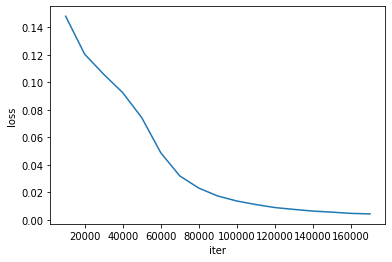

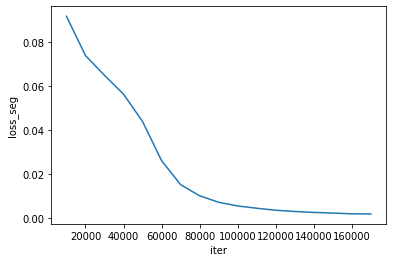

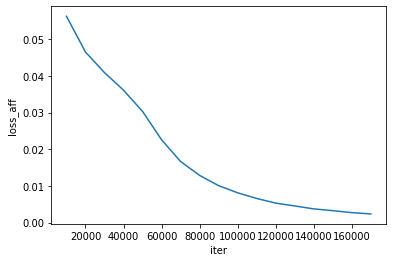

iter:170010, loss:0.0049, loss_seg:0.0023, loss_aff:0.0026
iter:170020, loss:0.0038, loss_seg:0.0012, loss_aff:0.0026
iter:170030, loss:0.0028, loss_seg:0.0012, loss_aff:0.0016
iter:170040, loss:0.0020, loss_seg:0.0009, loss_aff:0.0011
iter:170050, loss:0.0049, loss_seg:0.0028, loss_aff:0.0021
iter:170060, loss:0.0034, loss_seg:0.0014, loss_aff:0.0019
iter:170070, loss:0.0112, loss_seg:0.0078, loss_aff:0.0033
iter:170080, loss:0.0033, loss_seg:0.0017, loss_aff:0.0016
iter:170090, loss:0.0029, loss_seg:0.0013, loss_aff:0.0016
iter:170100, loss:0.0050, loss_seg:0.0018, loss_aff:0.0032
iter:170110, loss:0.0017, loss_seg:0.0007, loss_aff:0.0010
iter:170120, loss:0.0029, loss_seg:0.0011, loss_aff:0.0019
iter:170130, loss:0.0056, loss_seg:0.0024, loss_aff:0.0032
iter:170140, loss:0.0063, loss_seg:0.0023, loss_aff:0.0040
iter:170150, loss:0.0034, loss_seg:0.0015, loss_aff:0.0018
iter:170160, loss:0.0025, loss_seg:0.0013, loss_aff:0.0013
iter:170170, loss:0.0057, loss_seg:0.0022, loss_aff:0.00

iter:171380, loss:0.0022, loss_seg:0.0012, loss_aff:0.0010
iter:171390, loss:0.0025, loss_seg:0.0010, loss_aff:0.0015
iter:171400, loss:0.0018, loss_seg:0.0011, loss_aff:0.0007
iter:171410, loss:0.0027, loss_seg:0.0012, loss_aff:0.0015
iter:171420, loss:0.0014, loss_seg:0.0006, loss_aff:0.0008
iter:171430, loss:0.0045, loss_seg:0.0019, loss_aff:0.0026
iter:171440, loss:0.0043, loss_seg:0.0018, loss_aff:0.0025
iter:171450, loss:0.0058, loss_seg:0.0019, loss_aff:0.0039
iter:171460, loss:0.0026, loss_seg:0.0013, loss_aff:0.0013
iter:171470, loss:0.0015, loss_seg:0.0007, loss_aff:0.0008
iter:171480, loss:0.0040, loss_seg:0.0014, loss_aff:0.0026
iter:171490, loss:0.0023, loss_seg:0.0010, loss_aff:0.0012
iter:171500, loss:0.0008, loss_seg:0.0004, loss_aff:0.0003
iter:171510, loss:0.0046, loss_seg:0.0021, loss_aff:0.0025
iter:171520, loss:0.0048, loss_seg:0.0024, loss_aff:0.0024
iter:171530, loss:0.0063, loss_seg:0.0046, loss_aff:0.0017
iter:171540, loss:0.0031, loss_seg:0.0016, loss_aff:0.00

iter:172750, loss:0.0015, loss_seg:0.0009, loss_aff:0.0006
iter:172760, loss:0.0015, loss_seg:0.0006, loss_aff:0.0009
iter:172770, loss:0.0021, loss_seg:0.0012, loss_aff:0.0009
iter:172780, loss:0.0033, loss_seg:0.0012, loss_aff:0.0021
iter:172790, loss:0.0024, loss_seg:0.0014, loss_aff:0.0011
iter:172800, loss:0.0074, loss_seg:0.0035, loss_aff:0.0039
iter:172810, loss:0.0047, loss_seg:0.0023, loss_aff:0.0024
iter:172820, loss:0.0114, loss_seg:0.0056, loss_aff:0.0058
iter:172830, loss:0.0093, loss_seg:0.0034, loss_aff:0.0059
iter:172840, loss:0.0108, loss_seg:0.0046, loss_aff:0.0062
iter:172850, loss:0.0122, loss_seg:0.0057, loss_aff:0.0065
iter:172860, loss:0.0098, loss_seg:0.0041, loss_aff:0.0058
iter:172870, loss:0.0171, loss_seg:0.0097, loss_aff:0.0074
iter:172880, loss:0.0194, loss_seg:0.0121, loss_aff:0.0073
iter:172890, loss:0.0064, loss_seg:0.0022, loss_aff:0.0041
iter:172900, loss:0.0173, loss_seg:0.0091, loss_aff:0.0081
iter:172910, loss:0.0215, loss_seg:0.0154, loss_aff:0.00

iter:174100, loss:0.0036, loss_seg:0.0013, loss_aff:0.0023
iter:174110, loss:0.0044, loss_seg:0.0022, loss_aff:0.0022
iter:174120, loss:0.0026, loss_seg:0.0011, loss_aff:0.0015
iter:174130, loss:0.0017, loss_seg:0.0008, loss_aff:0.0010
iter:174140, loss:0.0029, loss_seg:0.0014, loss_aff:0.0016
iter:174150, loss:0.0028, loss_seg:0.0009, loss_aff:0.0019
iter:174160, loss:0.0041, loss_seg:0.0016, loss_aff:0.0025
iter:174170, loss:0.0017, loss_seg:0.0011, loss_aff:0.0006
iter:174180, loss:0.0037, loss_seg:0.0019, loss_aff:0.0018
iter:174190, loss:0.0032, loss_seg:0.0011, loss_aff:0.0021
iter:174200, loss:0.0092, loss_seg:0.0057, loss_aff:0.0035
iter:174210, loss:0.0021, loss_seg:0.0010, loss_aff:0.0010
iter:174220, loss:0.0042, loss_seg:0.0019, loss_aff:0.0024
iter:174230, loss:0.0042, loss_seg:0.0015, loss_aff:0.0027
iter:174240, loss:0.0021, loss_seg:0.0008, loss_aff:0.0012
iter:174250, loss:0.0023, loss_seg:0.0010, loss_aff:0.0012
iter:174260, loss:0.0037, loss_seg:0.0017, loss_aff:0.00

iter:175490, loss:0.0023, loss_seg:0.0012, loss_aff:0.0011
iter:175500, loss:0.0014, loss_seg:0.0010, loss_aff:0.0005
iter:175510, loss:0.0017, loss_seg:0.0008, loss_aff:0.0009
iter:175520, loss:0.0012, loss_seg:0.0007, loss_aff:0.0006
iter:175530, loss:0.0019, loss_seg:0.0010, loss_aff:0.0010
iter:175540, loss:0.0010, loss_seg:0.0004, loss_aff:0.0006
iter:175550, loss:0.0028, loss_seg:0.0013, loss_aff:0.0015
iter:175560, loss:0.0012, loss_seg:0.0005, loss_aff:0.0007
iter:175570, loss:0.0027, loss_seg:0.0016, loss_aff:0.0012
iter:175580, loss:0.0036, loss_seg:0.0012, loss_aff:0.0024
iter:175590, loss:0.0021, loss_seg:0.0011, loss_aff:0.0010
iter:175600, loss:0.0012, loss_seg:0.0006, loss_aff:0.0006
iter:175610, loss:0.0061, loss_seg:0.0021, loss_aff:0.0040
iter:175620, loss:0.0026, loss_seg:0.0013, loss_aff:0.0012
iter:175630, loss:0.0013, loss_seg:0.0007, loss_aff:0.0006
iter:175640, loss:0.0012, loss_seg:0.0006, loss_aff:0.0006
iter:175650, loss:0.0012, loss_seg:0.0007, loss_aff:0.00

iter:176860, loss:0.0050, loss_seg:0.0018, loss_aff:0.0032
iter:176870, loss:0.0028, loss_seg:0.0010, loss_aff:0.0018
iter:176880, loss:0.0038, loss_seg:0.0016, loss_aff:0.0022
iter:176890, loss:0.0059, loss_seg:0.0021, loss_aff:0.0039
iter:176900, loss:0.0015, loss_seg:0.0006, loss_aff:0.0010
iter:176910, loss:0.0026, loss_seg:0.0014, loss_aff:0.0012
iter:176920, loss:0.0036, loss_seg:0.0016, loss_aff:0.0019
iter:176930, loss:0.0037, loss_seg:0.0012, loss_aff:0.0025
iter:176940, loss:0.0028, loss_seg:0.0013, loss_aff:0.0016
iter:176950, loss:0.0026, loss_seg:0.0013, loss_aff:0.0013
iter:176960, loss:0.0026, loss_seg:0.0009, loss_aff:0.0016
iter:176970, loss:0.0043, loss_seg:0.0026, loss_aff:0.0018
iter:176980, loss:0.0019, loss_seg:0.0008, loss_aff:0.0012
iter:176990, loss:0.0039, loss_seg:0.0019, loss_aff:0.0020
iter:177000, loss:0.0036, loss_seg:0.0016, loss_aff:0.0020
iter:177010, loss:0.0039, loss_seg:0.0017, loss_aff:0.0022
iter:177020, loss:0.0063, loss_seg:0.0021, loss_aff:0.00

iter:178230, loss:0.0027, loss_seg:0.0014, loss_aff:0.0012
iter:178240, loss:0.0015, loss_seg:0.0005, loss_aff:0.0009
iter:178250, loss:0.0028, loss_seg:0.0015, loss_aff:0.0013
iter:178260, loss:0.0031, loss_seg:0.0012, loss_aff:0.0019
iter:178270, loss:0.0012, loss_seg:0.0006, loss_aff:0.0006
iter:178280, loss:0.0033, loss_seg:0.0017, loss_aff:0.0016
iter:178290, loss:0.0024, loss_seg:0.0012, loss_aff:0.0012
iter:178300, loss:0.0039, loss_seg:0.0016, loss_aff:0.0023
iter:178310, loss:0.0018, loss_seg:0.0007, loss_aff:0.0011
iter:178320, loss:0.0051, loss_seg:0.0024, loss_aff:0.0027
iter:178330, loss:0.0026, loss_seg:0.0013, loss_aff:0.0012
iter:178340, loss:0.0046, loss_seg:0.0018, loss_aff:0.0028
iter:178350, loss:0.0016, loss_seg:0.0007, loss_aff:0.0009
iter:178360, loss:0.0040, loss_seg:0.0012, loss_aff:0.0028
iter:178370, loss:0.0030, loss_seg:0.0012, loss_aff:0.0018
iter:178380, loss:0.0080, loss_seg:0.0035, loss_aff:0.0045
iter:178390, loss:0.0027, loss_seg:0.0012, loss_aff:0.00

In [21]:
single_ex = 3
iter_ = 1
running_loss = 0.0
running_loss_seg = 0.0
running_loss_aff = 0.0
y_loss_axis = []
y_loss_seg_axis = []
y_loss_aff_axis = []
x_axis = []

model.train()

for epoch in range(EPOCH):  
#     for i in range(1000):
#         data = [x[None] for x in tdw_dataset[single_ex]]
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels, t_aff = data
        inputs = inputs.to(device)
        labels = labels.type(torch.float32)
        labels = labels.to(device)
        t_aff = t_aff.type(torch.float32)
        t_aff = t_aff.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss_seg, loss_aff = calc_loss(outputs, labels, 
                                       t_aff, aff_calc_weight, 
                                       aff_weight, l_aff_weight)
        loss = loss_seg + loss_aff
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_loss_seg += loss_seg.data
        running_loss_aff += loss_aff.data

        iter_ += 1
        
        # logの表示
        if iter_ % LOG_ITER == 0:
            with open(name + "log", mode='a') as f:
                f.write("time:{}, epoch:{}, iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}\n"
                        .format(datetime.datetime.now(), epoch, iter_, 
                                loss.data, loss_seg.data, loss_aff.data))
            print("iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}"
                  .format(iter_, loss.data, loss_seg.data, loss_aff.data))

        if iter_ % SAVE_ITER == 0:
            # lossのグラフ作成
            x_axis.append(iter_)
            y_loss_axis.append(running_loss.item() / SAVE_ITER)
            y_loss_seg_axis.append(running_loss_seg.item() / SAVE_ITER)
            y_loss_aff_axis.append(running_loss_aff.item() / SAVE_ITER)

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss")
            plt.plot(np.array(x_axis),np.array(y_loss_axis))
#             fig.savefig(graph + "loss.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_seg")
            plt.plot(np.array(x_axis),np.array(y_loss_seg_axis))
#             fig.savefig(graph + "loss_seg.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_aff")
            plt.plot(np.array(x_axis),np.array(y_loss_aff_axis))
#             fig.savefig(graph + "loss_aff.png")            

            plt.show()
    
            running_loss = 0.0
            running_loss_seg = 0.0
            running_loss_aff = 0.0

            torch.save(model.state_dict(), trained_model + "model_" + str(iter_) + ".pth")

print('Finished Training')

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


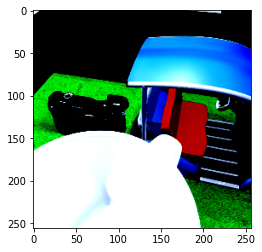

In [83]:
plt.imshow(inputs[0].permute(1,2,0).cpu())
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


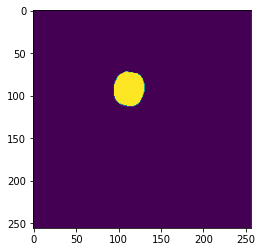

In [47]:
plt.imshow(labels[0].permute(1,2,0).cpu()[:,:,0])
plt.show()

# test on tdw

In [48]:
model.eval()
tdw_val_dataset = datasets.TdwAffinityDataset(training=False, mean=mean, std=std, raft_ckpt=None, 
                                              full_supervision=True)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
ex = 1
img, cats, _ = [x[None].cuda() for x in tdw_val_dataset[ex]]
outputs = model(img)
ins, ins_list = make_ins_seg(outputs, st_for=0,
                            en_for=5, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


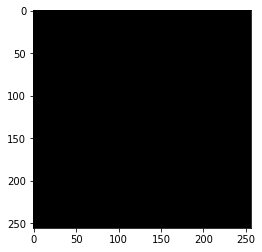

In [56]:
cls_ = 0
print(np.unique(ins[cls_]))
plt.imshow(ins[cls_])
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


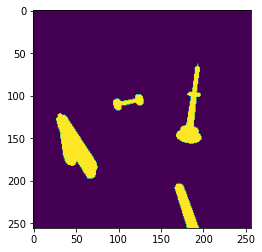

In [57]:
plt.imshow(cats[0].detach().cpu().numpy()[0])

# test

In [19]:
# # 評価するモデルとiterationを指定.
# pre_name = "../exp/exp_1/"
# iter_ = "750000"
# model = SSAP(n_channels=3, n_classes=len(t_color), aff_r=AFF_R)
# model = model.to(device)
# model.eval()
# model.load_state_dict(torch.load(pre_name + 'trained_model/model_' + iter_ + '.pth'))

<All keys matched successfully>

In [20]:
model.eval()
print(num_parameters(model))

48401722


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
data_type = "val"
img_path = sorted(glob.glob(DATA_PATH + data_type + "2017/*"))
img_t_path = sorted(glob.glob(DATA_PATH + "semantic_" + data_type + "/*"))
img_ins_t_path = sorted(glob.glob(DATA_PATH + "instance_" + data_type + "/*"))
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# cocoデータセット呼び出し
annFile='../data/annotations/instances_%s2017.json'%(data_type)
coco=COCO(annFile)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [23]:
# クラスとcocoデータセット内でのIndexを渡すと、評価データ内のIndexを返す.
def get_img_ind(cls_ind=0, img_ind=0):
    catIds = coco.getCatIds(catNms=[t_class_name[cls_ind]]);
    imgIds = sorted(coco.getImgIds(catIds=catIds));
    img_name = coco.loadImgs(imgIds[img_ind])[0]['file_name']
    img_name = DATA_PATH + data_type + "2017/" + img_name
    ind_ = img_path.index(img_name)
    print(t_class_name[cls_ind], ind_)
    return ind_

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Semantic Segmentation
def semantic(ind=0, cls_=0):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                     & (img_t[:, :, 1] == t_color[cls_][1])
                     & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))
    output = np.where(output==cls_, 1, 0)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(output)
    plt.show()

    return outputs

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Instance Segmentation
def instance(ind=0, cls_=0, st_for=0, en_for=5, min_size=5):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                      & (img_t[:, :, 1] == t_color[cls_][1])
                      & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))
    
    ins, ins_list = make_ins_seg(outputs, st_for=st_for,
                                 en_for=en_for, min_size=min_size)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(ins[cls_])
    plt.show()

    return outputs, ins

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 0
pic_name:../data/resize/val2017/000000000139.jpg


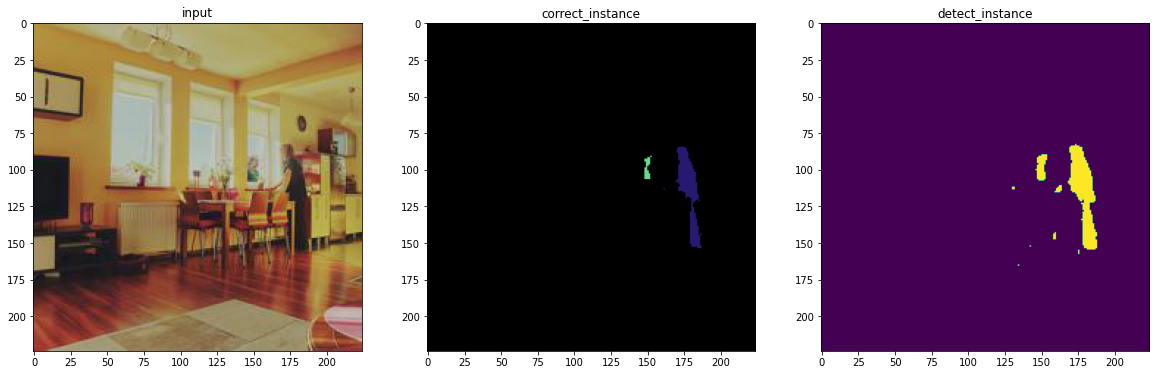

In [26]:
cls_ind = 0
img_ind = 0
ind = get_img_ind(cls_ind, img_ind)
outputs = semantic(ind=ind, cls_=cls_ind)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 0
pic_name:../data/resize/val2017/000000000139.jpg


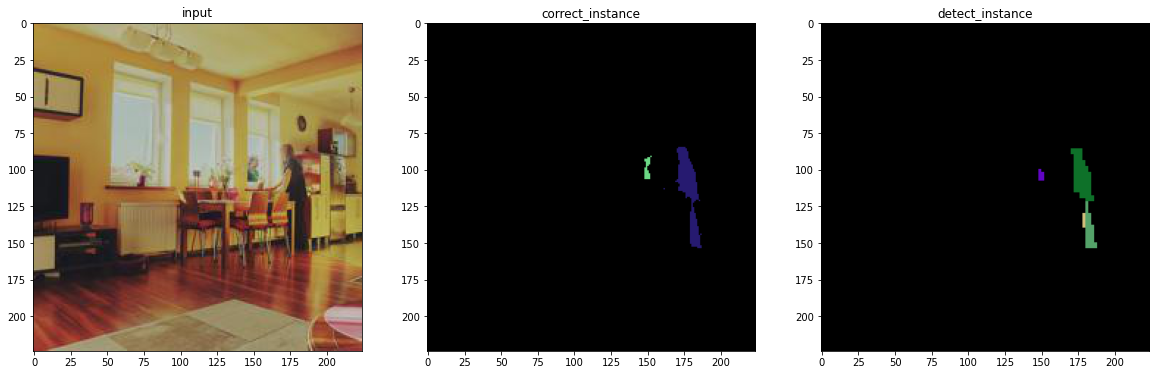

In [33]:
cls_ind = 0
img_ind = 0
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 1845
pic_name:../data/resize/val2017/000000212453.jpg


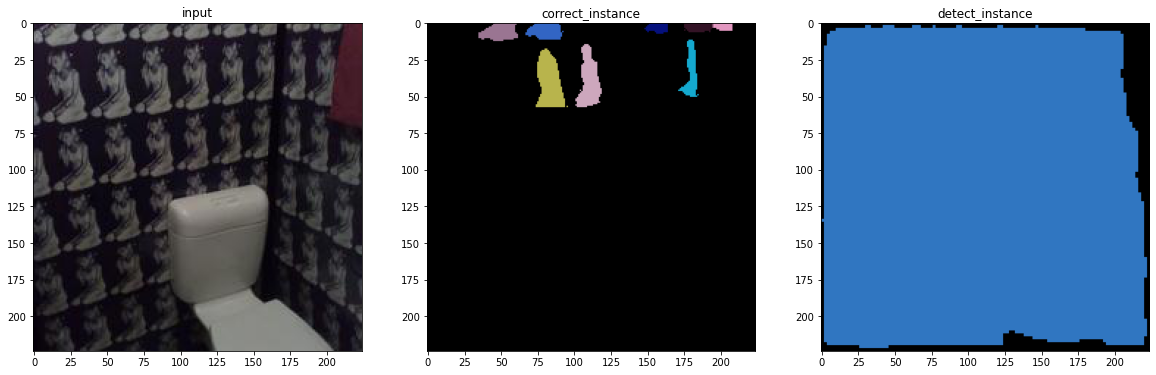

In [26]:
cls_ind = 0
img_ind = 1000
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


person 191
pic_name:../data/resize/val2017/000000019221.jpg


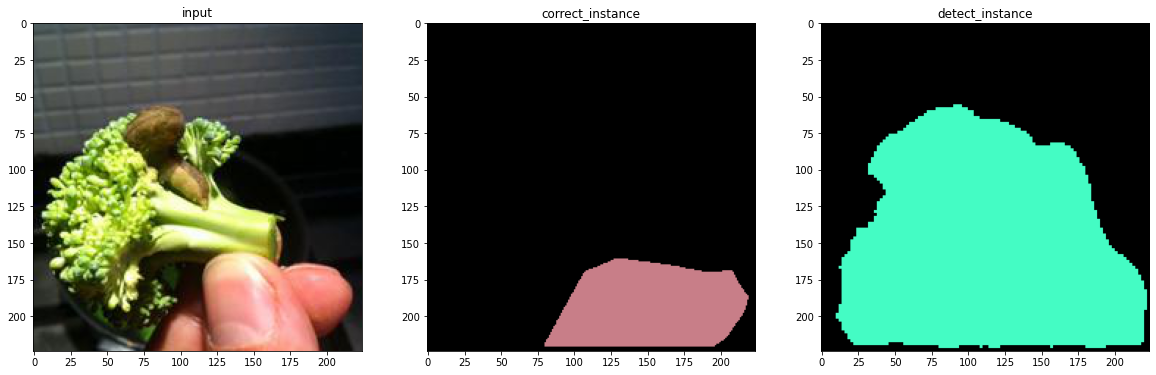

In [27]:
cls_ind = 0
img_ind = 105
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


elephant 710
pic_name:../data/resize/val2017/000000083113.jpg


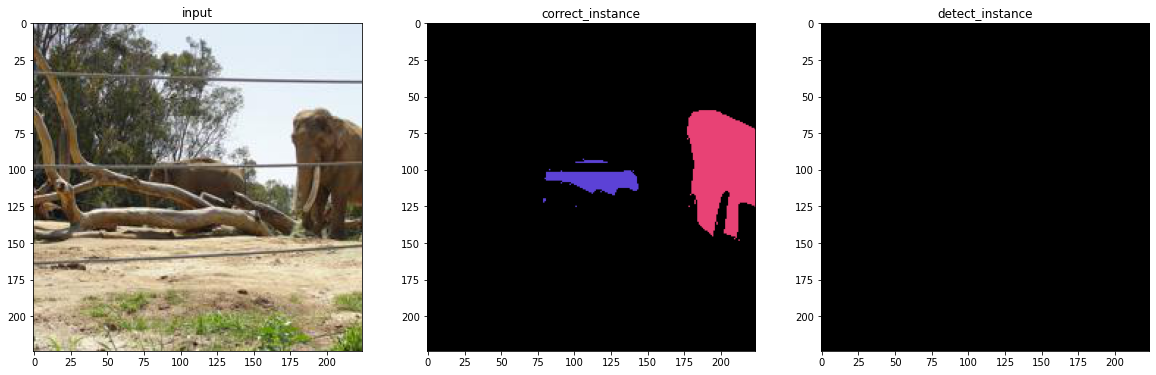

In [29]:
cls_ind = 20
img_ind = 10
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

keyboard 2630
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000036484.jpg


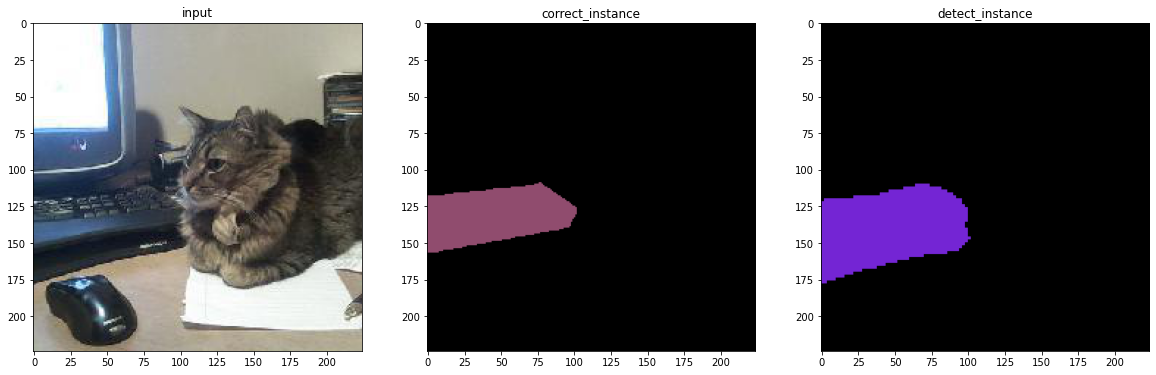

In [21]:
cls_ind = 66
img_ind = 44
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

stop sign 401
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000005635.jpg


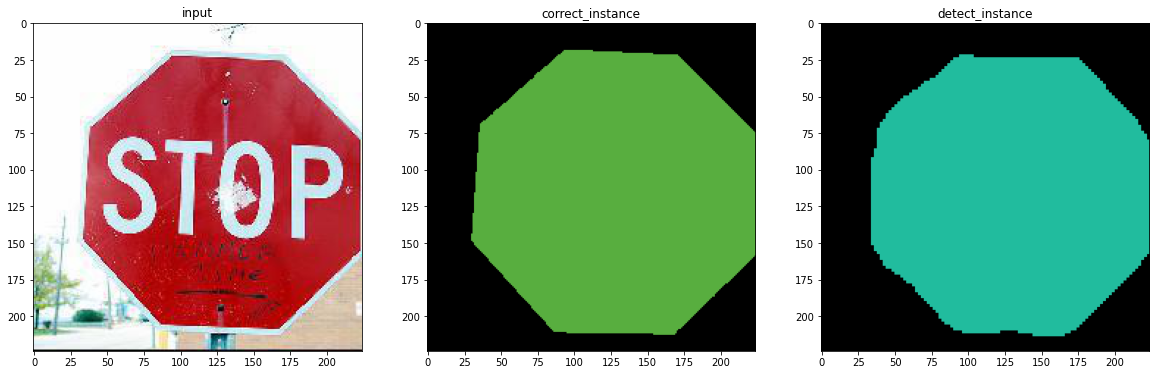

In [42]:
cls_ind = 11
img_ind = 3
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

fork 24806
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000356349.jpg


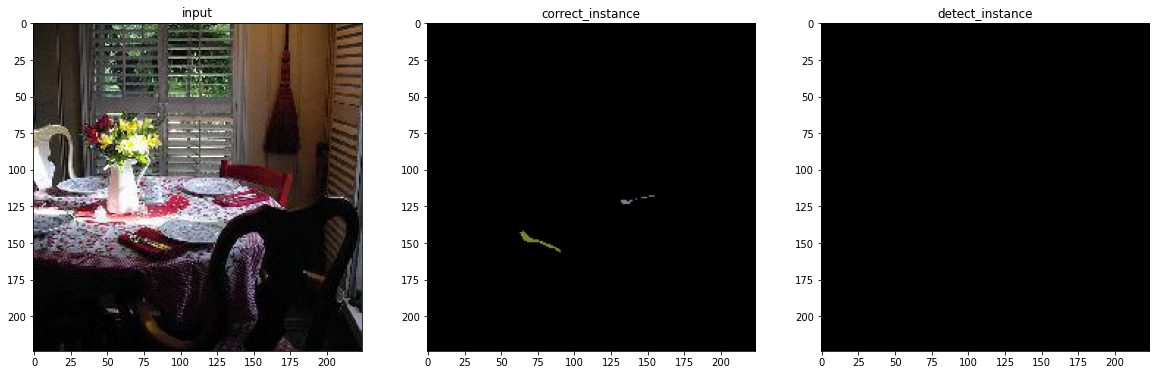

In [63]:
cls_ind = 42
img_ind = 736
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

## Calc metrics

In [21]:
# mIoU
intersection = np.zeros((len(t_color)-1))
union = np.zeros((len(t_color)-1))
iou = np.zeros((len(t_color)-1))
t_area = np.zeros((len(t_color)-1))

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))

    img = preprocess(img)

    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))
    inputs[0] = transform(img)

    with torch.no_grad():
        outputs = model(inputs.to(device))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))

    for cls_ in range(len(t_color)-1):
        output_cls = np.where(output==cls_, 1, 0)
        img_t_cls = np.where((img_t[:, :, 0] == t_color[cls_][0])
                             & (img_t[:, :, 1] == t_color[cls_][1])
                             & (img_t[:, :, 2] == t_color[cls_][2]), 1, 0)
        union[cls_] += np.sum(np.where((output_cls + img_t_cls)>0, 1, 0))
        intersection[cls_] += np.sum(output_cls * img_t_cls)
        t_area[cls_] += np.sum(img_t_cls)

for cls_ in range(len(t_color)-1):
    if union[cls_] == 0:
        iou[cls_] = 0
    else:
        iou[cls_] = intersection[cls_] / union[cls_]

with open(metrics + "metrics_mIoU", mode='w') as f:
    f.write("mIoU:{:.3f}\n"
            .format(np.mean(np.array(iou))))
    for i in range(len(t_color)-1):
        f.write("{}, IoU:{:.3f}, {}, union:{}, t_area:{}, intersection:{}\n"
            .format(i, iou[i], t_class_name[i], union[i],
                    t_area[i], intersection[i]))

np.save(metrics + 'intersection', intersection)
np.save(metrics + 'union', union)
np.save(metrics + 'iou', iou)
np.save(metrics + 't_area', t_area)

100%|██████████| 40504/40504 [53:01<00:00, 12.73it/s]


In [ ]:
# PQ(Panoptic Quality), AP(Average Precision)の計算
TP = np.zeros((len(t_color)-1))
FP = np.zeros((len(t_color)-1))
FN = np.zeros((len(t_color)-1))
IoU_05 = [[] for i in range(len(t_color)-1)]
IoU = np.zeros((len(t_color)-1))
AP = np.zeros((len(t_color)-1))
SQ = np.zeros((len(t_color)-1))
RQ = np.zeros((len(t_color)-1))

st_for=0
en_for=4
min_size=20

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    seg_t = np.asarray(Image.open(img_t_path[ind]))
    ins_t = np.asarray(Image.open(img_ins_t_path[ind]))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
        
    detect, ins_list = make_ins_seg(outputs, st_for=st_for,
                                    en_for=en_for, min_size=min_size)

    for cls_ in range(len(t_color)-1):
        # Falseだと、そのクラスが画像中に存在していないことを示す.
        t_flag = False
        d_flag = False

        # 正解ラベル
        # 該当クラスのinstanceのみ取り出す
        mask = np.where((seg_t[:, :, 0] == t_color[cls_][0])
                        & (seg_t[:, :, 1] == t_color[cls_][1])
                        & (seg_t[:, :, 2] == t_color[cls_][2]),
                        1, 0)[..., None]
        ins_t_cls = ins_t * mask
        if np.max(ins_t_cls)!=0:
            t_flag = True
            # instanceを一つずつ224x224のndarrayに分ける
            ins_colors = ins_t_cls.reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            t_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))

            for i in range(len(ins_colors)):
                t_com[i] = np.where((ins_t_cls[:, :, 0] == ins_colors[i][0])
                                    & (ins_t_cls[:, :, 1] == ins_colors[i][1])
                                    & (ins_t_cls[:, :, 2] == ins_colors[i][2]), 1, 0)

        # 識別結果
        # instanceを一つずつ224x224のndarrayに分ける
        if np.max(detect[cls_])!=0:
            d_flag = True
            ins_colors = detect[cls_].reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            det_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))
            for i in range(len(ins_colors)):
                det_com[i] = np.where((detect[cls_][:, :, 0] == ins_colors[i][0])
                                      & (detect[cls_][:, :, 1] == ins_colors[i][1])
                                      & (detect[cls_][:, :, 2] == ins_colors[i][2]), 1, 0)

        # t_comとdet_comを比較.
        if t_flag == False and d_flag == False:
            continue
        elif t_flag == True and d_flag == False:
            FN[cls_] += len(t_com)
        elif t_flag == False and d_flag == True:
            FP[cls_] += len(det_com)
        else:
            TP_cls = 0
            for i in range(len(det_com)):
                union = np.sum(np.sum(np.clip(t_com + det_com[i], 0, 1), axis=2), axis=1)
                intersection = np.sum(np.sum(t_com * det_com[i], axis=2), axis=1)

                max_IoU = np.max(intersection / union)
                if max_IoU > 0.5:
                    TP_cls += 1
                    IoU[cls_] += max_IoU
                    IoU_05[cls_].append(max_IoU)
            TP[cls_] += TP_cls
            FP[cls_] += len(det_com) - TP_cls
            FN[cls_] += len(t_com) - TP_cls
            
    if ind % 100 == 0:
        with open(metrics + "log", mode='a') as f:
            f.write("index:{}\n".format(ind))

np.save(metrics + 'TP', TP)
np.save(metrics + 'FP', FP)
np.save(metrics + 'FN', FN)
np.save(metrics + 'PQ_IoU', IoU)

for cls_ in range(len(t_color)-1):
    # Segmentation Quality
    if TP[cls_] == 0:
        SQ[cls_] = 0
    else:
        SQ[cls_] = np.array(IoU[cls_]) / np.array(TP[cls_])
    # Recognition Quality
    denominator = TP[cls_] + FP[cls_]/2 + FN[cls_]/2
    if denominator == 0:
        RQ[cls_] = 0
    else:
        RQ[cls_] = TP[cls_] / denominator
    
    # APの計算
    TP_FP = TP[cls_] + FP[cls_]
    if TP_FP == 0:
        AP[cls_] = 0
        continue
    for thresh in range(50, 100, 5):
        th = thresh / 100
        iou_05 = np.asarray(IoU_05[cls_])
        AP[cls_] += np.sum(np.where(iou_05>th, 1, 0)) / TP_FP
AP = AP / 10

# Panoptic Quality
PQ = SQ * RQ

with open(metrics + "metrics_mAP_mPQ", mode='w') as f:
    f.write("mAP{}, mPQ:{}\n"
            .format(np.mean(AP), np.mean(PQ)))
    for i in range(len(t_color)-1):
        f.write("{}, AP:{:.3f}, PQ:{:.3f}, {}\n"
            .format(i, AP[i], PQ[i], t_class_name[i]))

np.save(metrics + 'SQ', SQ)
np.save(metrics + 'RQ', RQ)
np.save(metrics + 'PQ', PQ)
np.save(metrics + 'AP', AP)